# Notebook 009: Initial EDA for Crime Incident Reports

This notebooks contains preliminary EDA for Boston crime incident report records.

Note that this is not a complete EDA, but has just been created to begin to understand the structure of this dataset and how other datasets might be used to enrich it with additional features

In [1]:
import urllib
import os
import operator
import pathlib
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline

In [105]:
DATA_ROOT = '../data/'
FIGURES_ROOT = '../figures/crime'

READDIR_ROOT = os.path.join(DATA_ROOT, 'raw')
WRITEDIR_ROOT = os.path.join(DATA_ROOT, 'interim/crime')
FEATURES_ROOT = os.path.join(DATA_ROOT, 'processed')

readfile_crime = os.path.join(READDIR_ROOT, 'crime/crime-incidents.csv')
readfile_crime_match_key = '../crime-offense-match-key.csv'
readfile_crime_match_key_2 = '../crime-offense-match-key-v2.csv'

readfile_sam = os.path.join(READDIR_ROOT, 'boston/sam-addresses.csv')
readfile_zipshapes = os.path.join(READDIR_ROOT, 'shapefile/zipcodes/ZIP_Codes.shp')
readfile_cityshape = os.path.join(READDIR_ROOT, 'shapefile/city-boundary/City_of_Boston_Boundary.shp')
readfile_streetshapes = os.path.join(READDIR_ROOT, 'shapefile/street-segments/Boston_Street_Segments.shp')
readfile_tractshapes = os.path.join(READDIR_ROOT, 'shapefile/census-tracts/Census_2010_Tracts.shp')
readfile_hoodshapes = os.path.join(READDIR_ROOT, 'shapefile/boston-neighborhoods/Boston_Neighborhoods.shp')
readfile_zonesubshapes = os.path.join(READDIR_ROOT, 'shapefile/zoning-subdistricts/Zoning_Subdistricts.shp')
readfile_openshapes = os.path.join(READDIR_ROOT, 'shapefile/open-spaces/Open_Space.shp')
readfile_feat_property = os.path.join(FEATURES_ROOT, 'property-assessment-features-2013-2019.csv')

print(
    'readfile paths for datasets used in this notebook are:\n\t{}\n\t{}\n\t{}'.format(
        readfile_crime, readfile_sam, readfile_zipshapes, WRITEDIR_ROOT
    )
)

readfile paths for datasets used in this notebook are:
	../data/raw/crime/crime-incidents.csv
	../data/raw/boston/sam-addresses.csv
	../data/raw/shapefile/zipcodes/ZIP_Codes.shp


In [3]:
# mkdir for saving figures if it doesn't already exist
if not os.path.exists(FIGURES_ROOT):
    os.mkdir(FIGURES_ROOT)
    
# mkdir for saving figures if it doesn't already exist
if not os.path.exists(WRITEDIR_ROOT):
    os.mkdir(WRITEDIR_ROOT)

In [4]:
# read in required data and related shapefiles
df_crime = pd.read_csv(readfile_crime, dtype=str)
df_offense_mapkey = pd.read_csv(readfile_crime_match_key)
df_offense_mapkey_2 = pd.read_csv(readfile_crime_match_key_2)
df_sam = pd.read_csv(readfile_sam, dtype=str)
gdf_zips = gpd.read_file(readfile_zipshapes)
gdf_boston = gpd.read_file(readfile_cityshape)
gdf_streets = gpd.read_file(readfile_streetshapes)
gdf_tracts = gpd.read_file(readfile_tractshapes)
gdf_hoods = gpd.read_file(readfile_hoodshapes)
gdf_zonesubs = gpd.read_file(readfile_zonesubshapes)
gdf_openspace = gpd.read_file(readfile_openshapes)

df_feat_prop = pd.read_csv(readfile_feat_property, dtype={'shape-id': str, 'fiscal-year': int})

# convert SAM data lat/lon values to floats
df_sam[['X', 'Y']] = df_sam[['X', 'Y']].astype(float)
# convert crime data lat/lon values to floats
df_crime[['Lat', 'Long']] = df_crime[['Lat', 'Long']].astype(float)

In [5]:
# check info of crime dataframe
df_crime.info()
df_crime.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436666 entries, 0 to 436665
Data columns (total 17 columns):
INCIDENT_NUMBER        436666 non-null object
OFFENSE_CODE           436666 non-null object
OFFENSE_CODE_GROUP     426840 non-null object
OFFENSE_DESCRIPTION    436666 non-null object
DISTRICT               434440 non-null object
REPORTING_AREA         436666 non-null object
SHOOTING               11573 non-null object
OCCURRED_ON_DATE       436666 non-null object
YEAR                   436666 non-null object
MONTH                  436666 non-null object
DAY_OF_WEEK            436666 non-null object
HOUR                   436666 non-null object
UCR_PART               426730 non-null object
STREET                 423236 non-null object
Lat                    399636 non-null float64
Long                   399636 non-null float64
Location               436666 non-null object
dtypes: float64(2), object(15)
memory usage: 56.6+ MB


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,TESTTEST2,423,NaN,ASSAULT - AGGRAVATED,External,,0,2019-10-16 00:00:00,2019,10,Wednesday,0,NaN,RIVERVIEW DR,NaN,NaN,"(0.00000000, 0.00000000)"
1,I92089785,3005,NaN,SICK ASSIST,E13,574,0,2019-11-05 18:00:00,2019,11,Tuesday,18,NaN,WASHINGTON ST,NaN,NaN,"(0.00000000, 0.00000000)"
2,I90583827,1402,NaN,VANDALISM,E18,498,0,2019-11-02 05:09:00,2019,11,Saturday,5,NaN,BRADLEE ST,NaN,NaN,"(0.00000000, 0.00000000)"
3,I192082859,00724,Auto Theft,AUTO THEFT,E18,519,NaN,2019-10-13 09:28:24,2019,10,Sunday,9,Part One,LINCOLN ST,42.259518,-71.121563,"(42.25951765, -71.12156299)"
4,I192082751,00724,Auto Theft,AUTO THEFT,E18,493,NaN,2019-10-12 20:11:26,2019,10,Saturday,20,Part One,METROPOLITAN AVE,42.262092,-71.116710,"(42.26209214, -71.11670964)"


In [6]:
# change datatypes for crime data columns as needed
df_crime['MONTH'] = df_crime['MONTH'].astype(int)
df_crime['HOUR'] = df_crime['HOUR'].astype(int)

In [7]:
# count records per calendar year
crime_count_year = df_crime['YEAR'].value_counts(dropna=False).sort_index()

# identify minimum and maximum month with records for each given year
min_max_months_year = {
    year: (min(month_set), max(month_set))
    for year, month_set in zip(
        crime_count_year.index,
        [
            set(df_crime.loc[df_crime['YEAR']==year]['MONTH'].values)
            for year in crime_count_year.index
        ]
    )
}

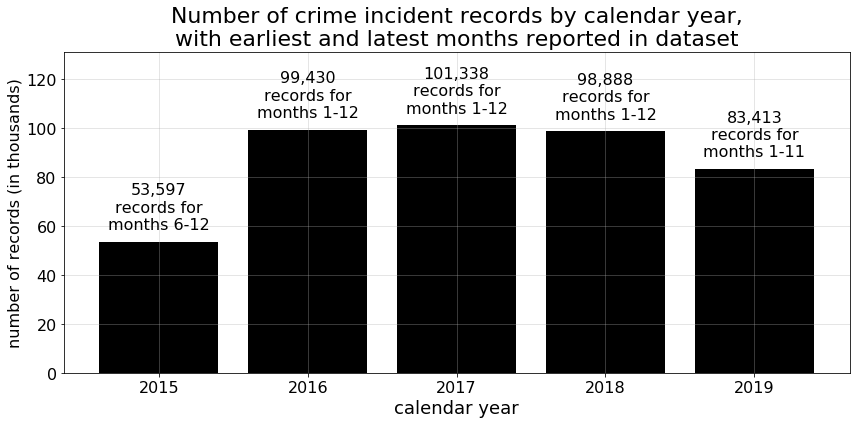

In [8]:
# print summary of years for all data records to identify partial years

savefig = True
scale = 1000
text_offset = 5
yscale_offset = 30

fig, ax = plt.subplots(figsize=(12, 6))

plt.title(
    "Number of crime incident records by calendar year,\n"\
    "with earliest and latest months reported in dataset",
    fontsize=22,
)

plt.bar(crime_count_year.index, crime_count_year.values/scale, color='k')

for (i, (year, values)), count in zip(enumerate(min_max_months_year.items()), crime_count_year.values/scale):
    ax.text(
        i, count+text_offset,
        '{0:,}\nrecords for\nmonths {1}-{2}'.format(int(count*scale), values[0], values[1]),
        color='k',
        fontsize=16,
        horizontalalignment='center'
    ) 

ax.tick_params(labelsize=16)
ax.set_ylabel("number of records (in thousands)", fontsize=16)
ax.set_ylim(bottom=0, top=max(crime_count_year.values/scale)+yscale_offset)
ax.set_xlabel("calendar year", fontsize=18)
ax.grid(':', alpha=0.4)    
plt.tight_layout()
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'crime-reports-by-year.png'))
plt.show();

## Subset crime incident data to include only years of complete feature data

In [9]:
############################################################
## SUBSET DATAFRAME TO INCLUDE ONLY YEARS WITH COMPLETE DATA
############################################################
subset_years = ['2016', '2017', '2018', '2019']

df_crime = df_crime.loc[df_crime['YEAR'].isin(subset_years)]

print(
    'The crime incidents dataset was subset to include only years with'\
    'records for all calendar months (i.e. complete years of data).\n\n'\
    'The following calendar years were retained:\t{0}\n\n'\
    'The resulting dataframe contains {1:,} records, broken down by year as:\n\n'\
    '{2}'.format(subset_years, len(df_crime), df_crime['YEAR'].value_counts().sort_index())
)

The crime incidents dataset was subset to include only years withrecords for all calendar months (i.e. complete years of data).

The following calendar years were retained:	['2016', '2017', '2018', '2019']

The resulting dataframe contains 383,069 records, broken down by year as:

2016     99430
2017    101338
2018     98888
2019     83413
Name: YEAR, dtype: int64


In [10]:
## Identify invalid or missing location data for both lat and long columns
print(
    'A summary count of invalid coordinate data by value is shown below. '\
    'These are missing data points that must be resolved:\n\n'\
    'Invalid Latitude value counts:\n{0}\n\nInvalid Longitude value counts:\n{0}\n'\
    ''.format(
        df_crime.loc[
            (df_crime['Lat'].astype(float)<42) | (df_crime['Lat'].isnull())
        ]['Lat'].value_counts(dropna=False),
        df_crime.loc[
            (df_crime['Long'].astype(float)>-70) | (df_crime['Long'].isnull())
        ]['Long'].value_counts(dropna=False)
    )
    
)

A summary count of invalid coordinate data by value is shown below. These are missing data points that must be resolved:

Invalid Latitude value counts:
NaN     34902
-1.0      883
Name: Lat, dtype: int64

Invalid Longitude value counts:
NaN     34902
-1.0      883
Name: Lat, dtype: int64



In [11]:
# Map -1 lat and long values to np.nan for further cleansing
for variable in ['Lat', 'Long']:
    df_crime[variable] = df_crime[variable].replace({-1: np.nan})
    
# add binary label for records that have coords
df_crime['is_coord'] = df_crime['Lat'].notna().values.astype(int)

print(
    'Now the NaN values for both Lat and Long are:\n\n'
    '\tMissing Latitudes:\t{0:,}\n\tMissing Longitudes:\t{1:,}\n'.format(
        sum(df_crime['Lat'].isnull()),
        sum(df_crime['Long'].isnull())
    )
)

Now the NaN values for both Lat and Long are:

	Missing Latitudes:	35,785
	Missing Longitudes:	35,785



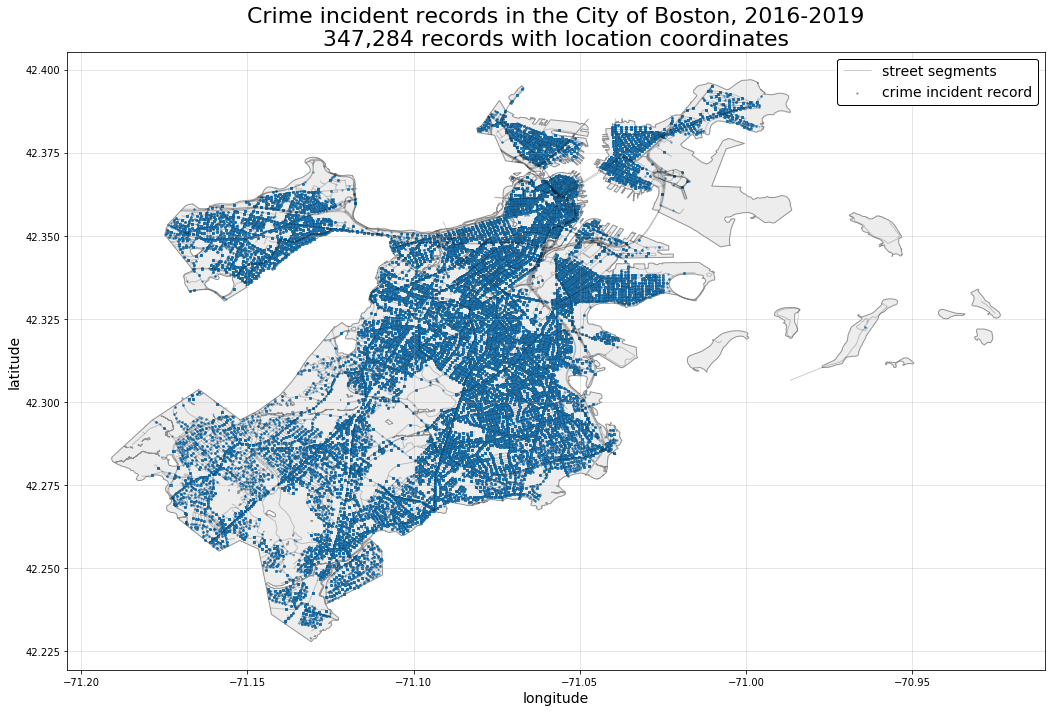

CPU times: user 17 s, sys: 1.21 s, total: 18.3 s
Wall time: 7.16 s


In [12]:
%%time
savefig=True

# plot unique SAM records with city boundary and street segments overlays 
fig, ax = plt.subplots(figsize=(16,10))
gdf_boston.plot(ax=ax, color='lightgray', edgecolor='k', alpha=0.4)
gdf_streets.plot(ax=ax, color='k', linewidth=1, alpha=0.2, label='street segments')
plt.title(
    'Crime incident records in the City of Boston, {0}-{1}\n'\
    '{2:,} records with location coordinates'.format(
        min(subset_years),
        max(subset_years),
        df_crime['is_coord'].sum(),
    ),
    fontsize=22
)
plt.scatter(
    df_crime['Long'], df_crime['Lat'],
    color='tab:blue', alpha=0.5, s=2,
    label='crime incident record'
)
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
plt.grid(":", alpha=0.4)
plt.legend(edgecolor='k', framealpha=1, fontsize=14)
plt.tight_layout()
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'crime-incidents-with-coords.png'))
plt.show();

## Label each record with corresponding shapefile polygon data based on record coordinates

In [13]:
# Define functions for converting dataframes to geodataframes, for matching polygons,
# and for merging match data back into original dataframe

def make_gdf_geometries(df_data, lon_col, lat_col, gdf_cols):
    """
    Creates GeoDataFrame with dataframe observations lat long points
    for joining to shapefile
    
    df_data: pandas.DataFrame, dataset with observations for matching
             to corresponding shapes
    lon_col: str, name of the Longitude column in df_data
    lat_col: str, name of the Latitude column in df_data
    gdf_cols: list of strings, the names of the df_data columns to include
              in the finished GeoDataFrame
    
    returns: GeoDataFrame containing specified columns and lat/lon points from
             df_data
    """
    # create geoseries of coordinate points for all records
    gs_points = gpd.GeoSeries(
        map(Point, zip(df_data[lon_col].values, df_data[lat_col].values))
    )

    # define our crs parameter for our coordinate reference system
    crs = {'init': 'epsg:4326'}

    # create a new geodataframe using df_sam as the base, define crs, and add in our point
    # geometries.
    gdf_data = gpd.GeoDataFrame(
        df_data[gdf_cols].reset_index(),
        crs=crs, geometry=gs_points
    )
    
    return gdf_data

    
def make_shapematch_gdf(gdf_data, gdf_shape, shapesname, no_copy_cols='geometry'):
    """
    Performs spatial join on GeoDataFrame input observations and corresponding shapefile
    to identify which shape each GeoDataFrame point is in.
    
    gdf_data: GeoDataFrame, of observed lat/lon points for which we want to match shapes
    gdf_shape: GeoDataFrame, contains polygons shapes on which to join gdf_data points
    shapesname: str, describing type of shapes being matched, for appending to new matched
                column names
    no_copy_cols: str or list of strings, specifying column names not to copy
    
    returns: 2 objects, (1) GeoDataFrame of spatial joined data, (2) list of column names
             generated for new values added to original GeoDataFrame
    """
    # make column name list for modifying merged names
    colnames = ['index_right']
    colnames.extend([
        colname for colname in gdf_shape.columns
        if colname not in no_copy_cols
    ])
    colnames_shape = [
        '{0}_{1}'.format(colname, shapesname)
        for colname in colnames
    ]
    len_colnames = len(colnames)

    # make certain we have a matching coordiate reference systems
    # assigned to our new GeoDataFrame and shapefile
    gdf_data.crs = gdf_shape.crs

    # then joing our two GeoDataFrames
    gdf_joined = gpd.sjoin(gdf_data, gdf_shape, how='left',op="within")
    
    gdf_joined = gdf_joined.rename(
        columns=dict(zip(colnames, colnames_shape))
    )
    
    return gdf_joined, colnames_shape

def merge_shapematch_df(df_data, gdf_joined, merge_cols):
    """
    Merges new spatial join columns to existing non-geo dataframe
    
    df_data: DataFrame, containing observations for which spatially joined
             data should be appended
    gdf_joined: GeoDataFrame, containing spatially joined observations
                each row corresponding with df_data observations
    merge_cols: list of strings, specifying with gdf_joined columns to 
                append to df_data
    
    returns: DataFrame of original observation data with new joined geo columns
             added to it
    """
    df_copy = df_data
    # add specified merge_cols to dataframe
    df_copy[merge_cols] = gdf_joined[merge_cols].copy()
    
    return df_copy
    

In [14]:
%%time

#######################################################################
# MATCH SHAPES FOR ALL RECORDS WITH COORDINATES AND APPEND TO DATAFRAME
#######################################################################

# create disctionary of shape files for matching
shape_gdfs_dict = {
    'zipcode': gdf_zips,
    'neighborhood': gdf_hoods,
    'censustract': gdf_tracts,
#     'zonesubdist': gdf_zonesubs,
}

# create crime geodataframe
gdf_crime = make_gdf_geometries(df_crime, 'Long', 'Lat', ['INCIDENT_NUMBER', 'is_coord'])

# append df_crime with new shape columns for each shapefile
for i, (key, gdf) in enumerate(shape_gdfs_dict.items()):
    df_crime = merge_shapematch_df(
        df_crime,
        *make_shapematch_gdf(gdf_crime, gdf, shapesname=key)
    )

CPU times: user 37.4 s, sys: 474 ms, total: 37.8 s
Wall time: 30.6 s


In [15]:
# inspect resulting shape-appended dataframe
print(df_crime.info())
df_crime.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383069 entries, 0 to 436665
Data columns (total 50 columns):
INCIDENT_NUMBER             383069 non-null object
OFFENSE_CODE                383069 non-null object
OFFENSE_CODE_GROUP          373243 non-null object
OFFENSE_DESCRIPTION         383069 non-null object
DISTRICT                    380972 non-null object
REPORTING_AREA              383069 non-null object
SHOOTING                    11322 non-null object
OCCURRED_ON_DATE            383069 non-null object
YEAR                        383069 non-null object
MONTH                       383069 non-null int64
DAY_OF_WEEK                 383069 non-null object
HOUR                        383069 non-null int64
UCR_PART                    373135 non-null object
STREET                      370911 non-null object
Lat                         347284 non-null float64
Long                        347284 non-null float64
Location                    383069 non-null object
is_coord               

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,...,MTFCC10_censustract,FUNCSTAT10_censustract,ALAND10_censustract,AWATER10_censustract,INTPTLAT10_censustract,INTPTLON10_censustract,Shape_STAr_censustract,Shape_STLe_censustract,Shape__Are_censustract,Shape__Len_censustract
0,TESTTEST2,423,NaN,ASSAULT - AGGRAVATED,External,,0,2019-10-16 00:00:00,2019,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,I92089785,3005,NaN,SICK ASSIST,E13,574,0,2019-11-05 18:00:00,2019,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,I90583827,1402,NaN,VANDALISM,E18,498,0,2019-11-02 05:09:00,2019,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I192082859,00724,Auto Theft,AUTO THEFT,E18,519,NaN,2019-10-13 09:28:24,2019,10,...,G5020,S,1547361.0,41485.0,+42.2587734,-071.1188131,1.710093e+07,24203.906315,2.902469e+06,9975.19967
4,I192082751,00724,Auto Theft,AUTO THEFT,E18,493,NaN,2019-10-12 20:11:26,2019,10,...,G5020,S,1547361.0,41485.0,+42.2587734,-071.1188131,1.710093e+07,24203.906315,2.902469e+06,9975.19967


In [16]:
# define function for plotting choropleth for quick check of record distributions
# across shapes by shapetype

def make_choropleth(gdf, variable, title, cb_label, cmap='Blues',
                    labels=None, savepath=None, citybounds=True):
    """
    plots choropleth
    
    gdf: the geopandas dataframe object containing the polygons and corresponding variable
         of interest
    variable: str, the column name for the variable of interest
    title: str, the title of the plot
    cb_label: str, the label for the colorbar
    cmap: str, the matplotlib predefined colormap colorscheme to use
    labels: boolean, will plot shape label if True. However coordinates for desired
            shapelabels need to stored in gdf in a column titled 'coords'
    savepath: None or str, filepath to which the plot should be saved. If None, the plot
              is not written to disk
    citybounds: boolean, if True, the city boundary for Boston is overlaid on the plot
    """
    # Now to add a colorbar for better interpretability of our choropleth plot

    # set min and max variable values for use in plotting our colorbar
    vmin = gdf[variable].describe()['min']
    vmax = gdf[variable].describe()['max']

    fig, ax = plt.subplots(figsize=(16,10))

    plt.title(
        title,
        fontsize=22
    )

    # NOTE: null values must be dropped from our df (as is shown below).
    #       Otherwise, the choropleth does not provide any gradation in color
    gdf.dropna(subset=[variable]).plot(
        column=variable,
        cmap=cmap,
        linewidth=1,
        ax=ax,
        edgecolor='k'
    )
    
    if citybounds:
        gdf_boston.plot(ax=ax, facecolor="none", edgecolor='k', alpha=0.4)

    # here we use the geopandas dataframe object's built-in iterrows() method
    # to turn zipshape_df into a generator object for iteration
    if labels:
        for idx, row in gdf.iterrows():
            plt.annotate(
                s=row[labels],
                xy=row['coords'],
                horizontalalignment='center',
                verticalalignment='center',
                weight='bold'
            )

    # here we create a colorbar legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

    # ...then we add the colorbar to the figure
    cbar = fig.colorbar(sm, ax=ax, shrink=.8, fraction=0.1)

    # ...and finally we format the colorbar for readability
    cbar.set_label(label='\n{}'.format(cb_label), fontsize=18)
    cbar.ax.tick_params(labelsize=14)

    plt.xlabel('longitude', fontsize=14)
    plt.ylabel('latitude', fontsize=14)
    plt.grid(":", alpha=0.4)
    plt.tight_layout()

    # save figure if savepath is entered
    if savepath:
        plt.savefig(savepath)
    plt.show();

In [17]:
# Prepare data for plotting crime incident choropleths

# set a few parameters for preparing data
shapedim_list = ['ZIP5_zipcode', 'Name_neighborhood', 'TRACTCE10_censustract']
joincol_list = ['ZIP5', 'Name', 'TRACTCE10']
shapetype_list = ['zipcode', 'neighborhood', 'census tract']

# create groupby counts for each shape of interest
crime_by_shape_list = [
    df_crime.groupby(shapedim).agg({
        'INCIDENT_NUMBER': 'count'
    }).rename({'INCIDENT_NUMBER': 'incidents'}, axis=1)
    for shapedim in shapedim_list
]

# label each shape in shapefile with shapename at representative coordinate
for gdf in [gdf_zips, gdf_hoods, gdf_tracts]:
    gdf['coords'] = gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
    gdf['coords'] = [coords[0] for coords in gdf['coords']]

# create joins with shapefiles to append with groupy counts for plotting
gdf_by_shape_dict = {
    shapetype: gdf.join(crime_by_shape, on=joincol)
    for shapetype, gdf, crime_by_shape, joincol in zip(
        shapetype_list,
        [gdf_zips, gdf_hoods, gdf_tracts],
        crime_by_shape_list,
        joincol_list
    )
}


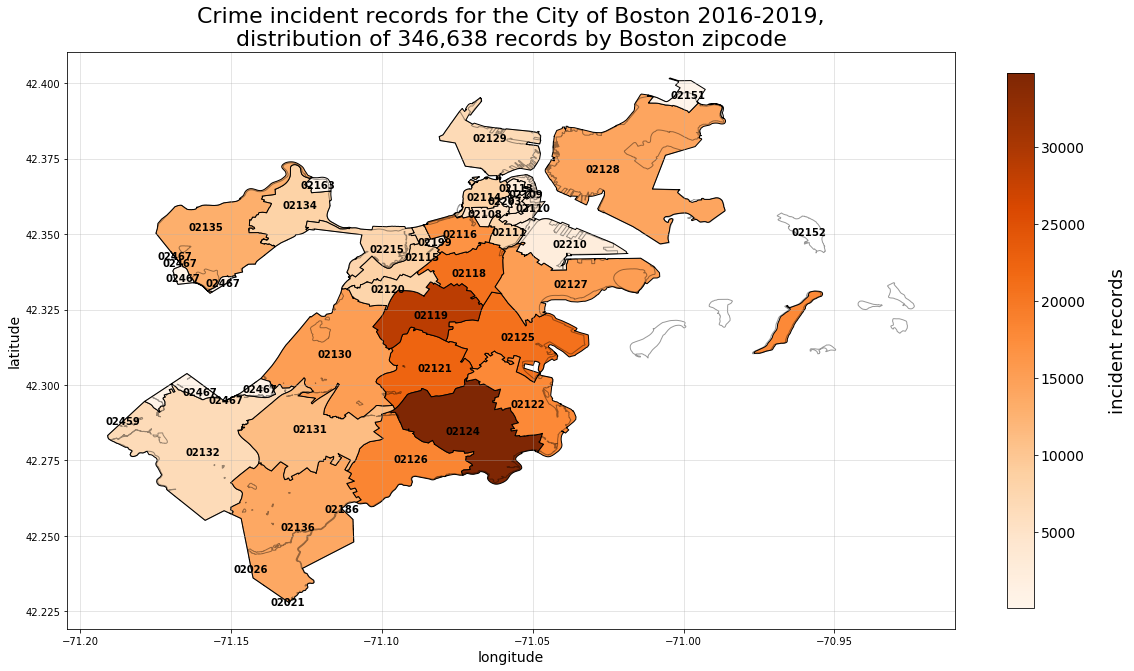

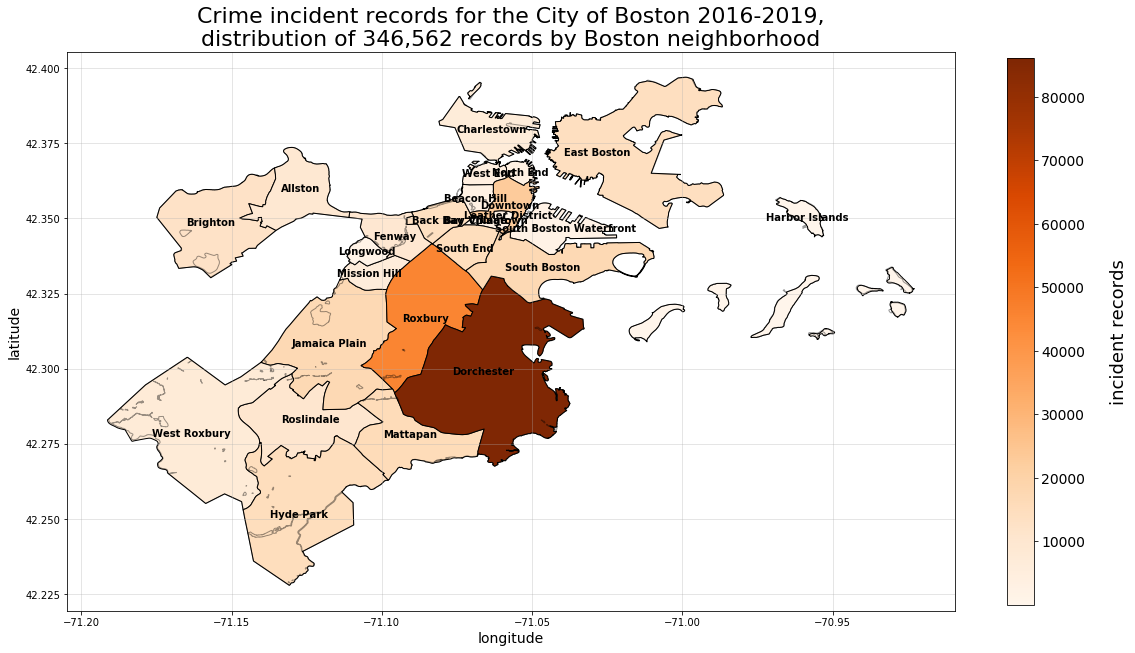

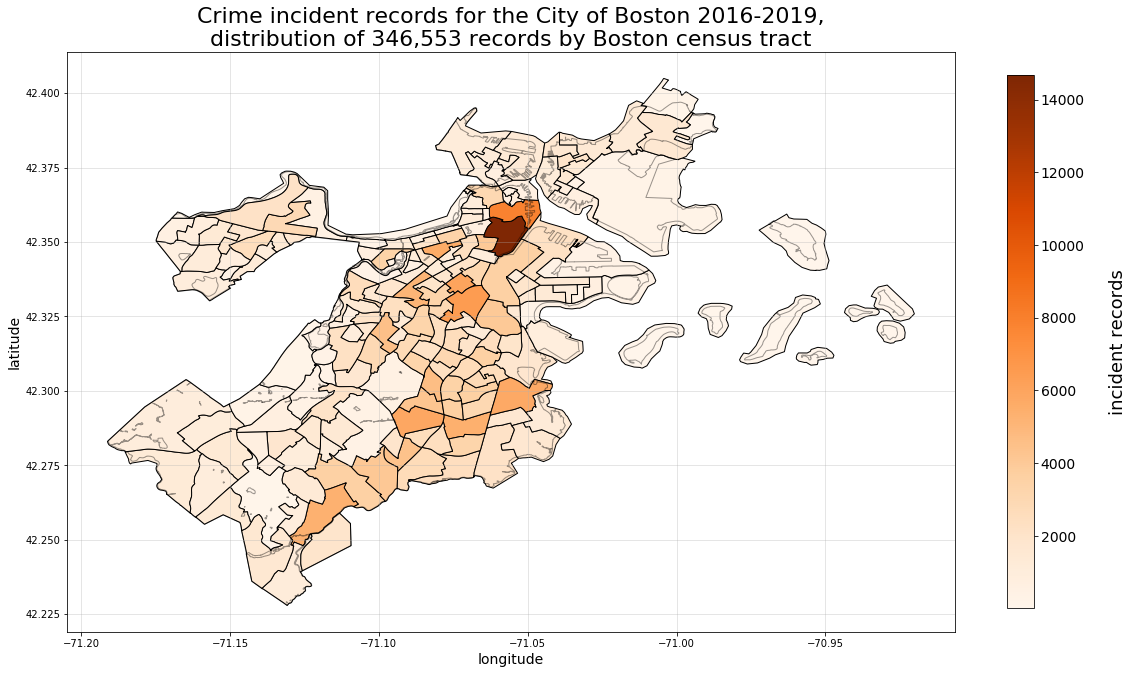

In [18]:
# Plot and save choropleths

# only label zipcodes and neighborhood, but not census tracts beacuse too small
labels_list = [joincol_list[0], joincol_list[1], None]

# set chart titles
titles_list = [
    'Crime incident records for the City of Boston {0}-{1},\n'\
    'distribution of {2:,} records by Boston {3}'.format(
        min(subset_years),
        max(subset_years),
        crime_by_shape.sum()[0],
        shapetype
    ) for shapetype, crime_by_shape in zip(
        shapetype_list, crime_by_shape_list
    )
]

# set savepaths
savepaths_list = [
    os.path.join(FIGURES_ROOT, 'crime-reports-by-{}.png'.format(shapetype))
    for shapetype in shapetype_list
]

for gdf, labels, title, savepath in zip(
    gdf_by_shape_dict.values(), labels_list, titles_list, savepaths_list
):
    make_choropleth(
        gdf, variable='incidents', title=title, cb_label='incident records',
        cmap='Oranges', labels=labels, savepath=savepath, citybounds=True
    )

## Inspect records with and without coordinates to identify potential biases for missing coordinate records

In [19]:
# calculate percentage of records with missing coords by year
missing_coords_year = df_crime.loc[
    df_crime['is_coord']==0
]['YEAR'].value_counts().sort_index() / df_crime['YEAR'].value_counts().sort_index()

# calculate percentage of records with missing coords by month for each year
missing_coords_month_year = [
    df_crime.loc[
        (df_crime['YEAR']==year) & (df_crime['is_coord']==0)
    ]['MONTH'].value_counts().sort_index() / df_crime.loc[df_crime['YEAR']==year]['MONTH'].value_counts().sort_index()
    for year in subset_years
]

# calculate percentage of records with missing coords by day of week
missing_coords_day = df_crime.loc[
    df_crime['is_coord']==0
]['DAY_OF_WEEK'].value_counts().sort_index() / df_crime['DAY_OF_WEEK'].value_counts().sort_index()
# sort days, sunday - saturday
missing_coords_day = missing_coords_day.loc[
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
]

# calculate percentage of records with missing coords by hour of day
missing_coords_hour = df_crime.loc[
    df_crime['is_coord']==0
]['HOUR'].value_counts().sort_index() / df_crime['HOUR'].value_counts().sort_index()

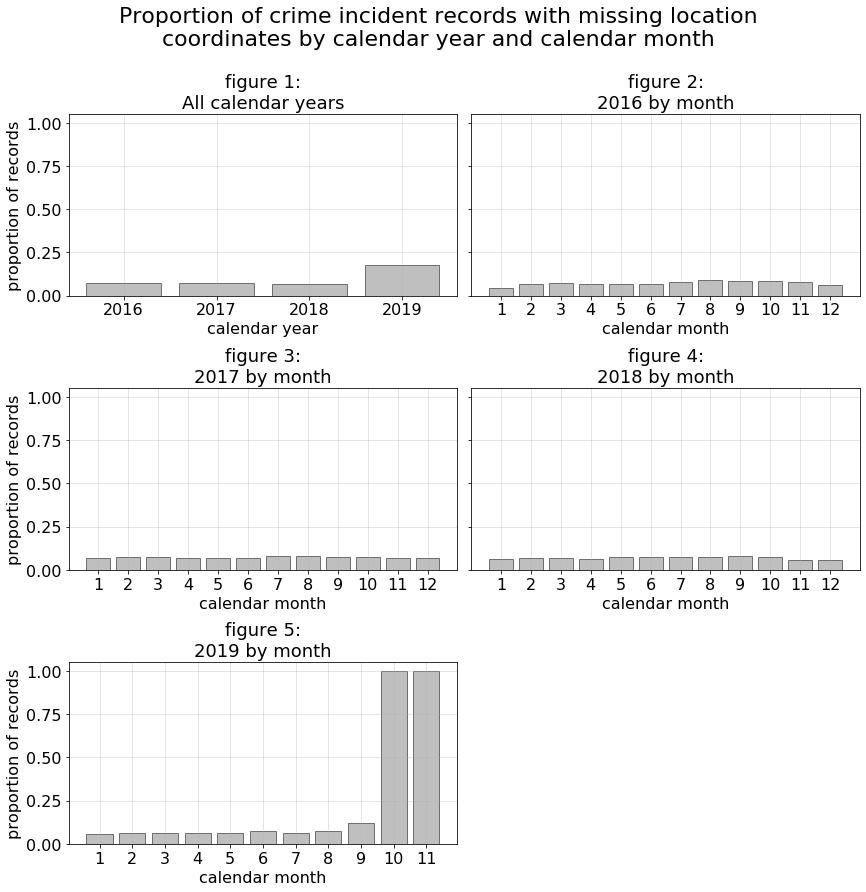

In [20]:
# print summary of years for all data records to identify partial years

savefig = True

fig, axes = plt.subplots(3,2, sharey=True, figsize=(12, 13))

plt.suptitle(
    "Proportion of crime incident records with missing location\n"\
    "coordinates by calendar year and calendar month",
    fontsize=22,
)

for (i, ax), data in zip(
    enumerate(axes.flat),
    [missing_coords_year, *missing_coords_month_year]
):
    ax.bar(data.index, data.values, color='gray', edgecolor='k', alpha=0.5)
    ax.tick_params(labelsize=16)
    ax.set_xticks(data.index)
    ax.grid(':', alpha=0.4)    
    if i == 0:
        ax.set_xlabel("calendar year", fontsize=16)
        ax.set_title('figure 1:\nAll calendar years', fontsize=18)
    else:
        ax.set_xlabel("calendar month", fontsize=16)
        ax.set_title(
            'figure {0}:\n{1} by month'.format(i+1, subset_years[i-1]),
            fontsize=18,
        )
    if i%2 == 0:
        ax.set_ylabel("proportion of records", fontsize=16)

# hide all markings for final 8th axis    
for pos in ['right','top','bottom','left']:
    axes[2,1].spines[pos].set_visible(False)
axes[2,1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes[2,1].tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

plt.tight_layout(rect=[0, 0.03, 1, 0.92])
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'crime-reports-missing-coords-year-month.png'))
plt.show();

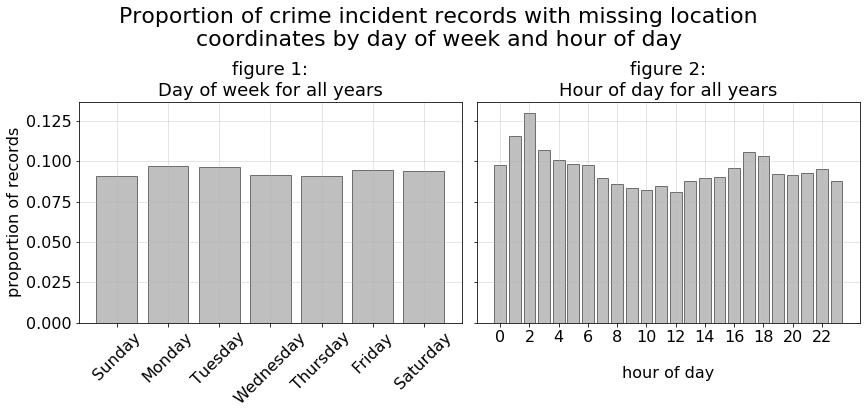

In [21]:
# print summary of years for all data records to identify partial years

savefig = True

fig, axes = plt.subplots(1,2, sharey=True, figsize=(12, 6))

plt.suptitle(
    "Proportion of crime incident records with missing location\n"\
    "coordinates by day of week and hour of day",
    fontsize=22,
)

for (i, ax), data in zip(
    enumerate(axes.flat),
    [missing_coords_day, missing_coords_hour]
):
    ax.bar(data.index, data.values, color='gray', edgecolor='k', alpha=0.5)
    ax.tick_params(labelsize=16)
    ax.set_xticks(data.index)
    ax.grid(':', alpha=0.4)    
    if i == 0:
        ax.set_xticklabels(data.index, rotation=45)
        ax.set_title('figure 1:\nDay of week for all years', fontsize=18)
        ax
    else:
        ax.set_xlabel("\nhour of day", fontsize=16)
        ax.set_xticks(data.index[::2])
        ax.set_xticklabels(data.index[::2])
        ax.set_title(
            'figure {0}:\nHour of day for all years'.format(i+1),
            fontsize=18,
        )
    if i%2 == 0:
        ax.set_ylabel("proportion of records", fontsize=16)
        

plt.tight_layout(rect=[0, 0.03, 1, 0.88])
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'crime-reports-missing-coords-day-hour.png'))
plt.show();

In [22]:
##############################################################
## DROP 2019 OCT AND NOV DATAPOINTS BECAUSE OF LOW COORD MATCH
##############################################################

df_crime = df_crime.loc[~((df_crime['YEAR']=='2019') & (df_crime['MONTH']>=9))]

print(
    'After removing the 2019 oct and nov records, there are {:,} records remaining'
    ''.format(len(df_crime))
)

After removing the 2019 oct and nov records, there are 365,188 records remaining


In [23]:
# calculate percentage of records with missing coords by year
missing_coords_year = df_crime.loc[
    df_crime['is_coord']==0
]['YEAR'].value_counts().sort_index() / df_crime['YEAR'].value_counts().sort_index()

# calculate percentage of records with missing coords by month for each year
missing_coords_month_year = [
    df_crime.loc[
        (df_crime['YEAR']==year) & (df_crime['is_coord']==0)
    ]['MONTH'].value_counts().sort_index() / df_crime.loc[df_crime['YEAR']==year]['MONTH'].value_counts().sort_index()
    for year in subset_years
]

# calculate percentage of records with missing coords by day of week
missing_coords_day = df_crime.loc[
    df_crime['is_coord']==0
]['DAY_OF_WEEK'].value_counts().sort_index() / df_crime['DAY_OF_WEEK'].value_counts().sort_index()
# sort days, sunday - saturday
missing_coords_day = missing_coords_day.loc[
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
]

# calculate percentage of records with missing coords by hour of day
missing_coords_hour = df_crime.loc[
    df_crime['is_coord']==0
]['HOUR'].value_counts().sort_index() / df_crime['HOUR'].value_counts().sort_index()

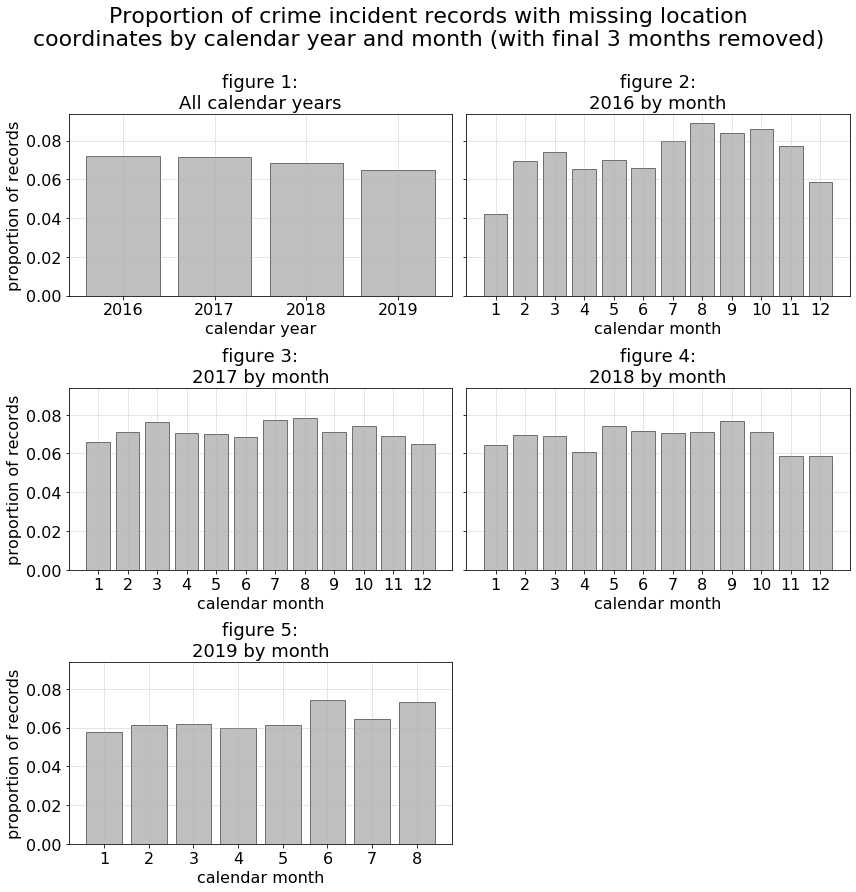

In [31]:
# print summary of years for all data records to identify partial years

savefig = True

fig, axes = plt.subplots(3,2, sharey=True, figsize=(12, 13))

plt.suptitle(
    "Proportion of crime incident records with missing location\n"\
    "coordinates by calendar year and month (with final 3 months removed)",
    fontsize=22,
)

for (i, ax), data in zip(
    enumerate(axes.flat),
    [missing_coords_year, *missing_coords_month_year]
):
    ax.bar(data.index, data.values, color='gray', edgecolor='k', alpha=0.5)
    ax.tick_params(labelsize=16)
    ax.set_xticks(data.index)
    ax.grid(':', alpha=0.4)    
    if i == 0:
        ax.set_xlabel("calendar year", fontsize=16)
        ax.set_title('figure 1:\nAll calendar years', fontsize=18)
    else:
        ax.set_xlabel("calendar month", fontsize=16)
        ax.set_title(
            'figure {0}:\n{1} by month'.format(i+1, subset_years[i-1]),
            fontsize=18,
        )
    if i%2 == 0:
        ax.set_ylabel("proportion of records", fontsize=16)

# hide all markings for final 8th axis    
for pos in ['right','top','bottom','left']:
    axes[2,1].spines[pos].set_visible(False)
axes[2,1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes[2,1].tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

plt.tight_layout(rect=[0, 0.03, 1, 0.92])
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'crime-reports-missing-coords-year-month-FINAL.png'))
plt.show();

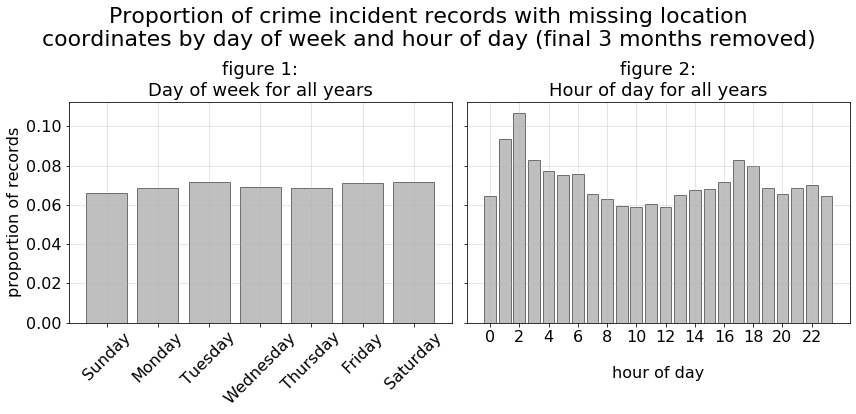

In [32]:
# print summary of years for all data records to identify partial years

savefig = True

fig, axes = plt.subplots(1,2, sharey=True, figsize=(12, 6))

plt.suptitle(
    "Proportion of crime incident records with missing location\n"\
    "coordinates by day of week and hour of day (final 3 months removed)",
    fontsize=22,
)

for (i, ax), data in zip(
    enumerate(axes.flat),
    [missing_coords_day, missing_coords_hour]
):
    ax.bar(data.index, data.values, color='gray', edgecolor='k', alpha=0.5)
    ax.tick_params(labelsize=16)
    ax.set_xticks(data.index)
    ax.grid(':', alpha=0.4)    
    if i == 0:
        ax.set_xticklabels(data.index, rotation=45)
        ax.set_title('figure 1:\nDay of week for all years', fontsize=18)
        ax
    else:
        ax.set_xlabel("\nhour of day", fontsize=16)
        ax.set_xticks(data.index[::2])
        ax.set_xticklabels(data.index[::2])
        ax.set_title(
            'figure {0}:\nHour of day for all years'.format(i+1),
            fontsize=18,
        )
    if i%2 == 0:
        ax.set_ylabel("proportion of records", fontsize=16)
        

plt.tight_layout(rect=[0, 0.03, 1, 0.88])
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'crime-reports-missing-coords-day-hour-FINAL.png'))
plt.show();

In [33]:
# define a vectorized function for calculating t-statistics to further investigate
# potential biases

def calc_t_stats(X_data, y_data, sort=False) -> pd.Series:
    """
    Calculates t_stats for all predictors in an X_data using 
    binary (1, 0) classifiers in a corresponding y_data
    
    X_data: pd.DataFrame containing predictors of interest and
            observed values for those predictors
    y_data: pd.Series containing binary (0,1) classifiers for
            variable of interest corresponding to all observed
            values X in X_data
    sort: boolean, default=False, determines whether the resulting
          t_stats series is sorted from largest to smallest values
    returns: pd.Series wherein the index are the predictor names
             and the values are the corresponding t_stats
    """
    # identify rows in dataset representing each response class 1 and 0 
    bool_1, bool_0 = (y_data.loc[:] == 1).values, (y_data.loc[:] == 0).values

    # subset X_data based on corresponding response classes
    X_1, X_0 = X_data.loc[bool_1], X_data.loc[bool_0]
    
    # calculate means for each subset of X values
    X_1_mean, X_0_mean = X_1.mean(axis=0), X_0.mean(axis=0)

    # calculate variances for each subset of X values
    X_1_var = X_1.var(axis=0)
    X_0_var = X_0.var(axis=0)

    # count number of observations in each subset of X values
    X_1_n = len(X_1)
    X_0_n = len(X_0)

    # calculate nominator and denominator for t_stat
    nom = (X_1_mean - X_0_mean).abs()
    denom = ((X_1_var/X_1_n) + (X_0_var/X_0_n))**.5
    
    # calculate and return t_stat, sorting values if specified
    if sort:
        return (nom / denom).sort_values(ascending=False)
    
    else:
        return (nom / denom)

In [34]:
# change all OFFENSE_CODE_GROUP and OFFENSE_DESCRIPTION values to lowercase
# and strip whitespace for better standardized values
df_crime['OFFENSE_CODE_GROUP'] = df_crime['OFFENSE_CODE_GROUP'].str.strip().str.lower()
df_crime['OFFENSE_DESCRIPTION'] = df_crime['OFFENSE_DESCRIPTION'].str.strip().str.lower()

# standardize OFFENSE_CODE digit length
df_crime['OFFENSE_CODE'] = ('00000' + df_crime['OFFENSE_CODE']).str[-5:]

# create a one-hot encoded subset dataframe containing only categories
# for 'OFFENSE_CODE_GROUP'
df_offense_groups = pd.get_dummies(df_crime['OFFENSE_CODE_GROUP'])

# calculate t-stats for offense group records with and without coordinates
offense_group_tstats = calc_t_stats(df_offense_groups, df_crime['is_coord'], sort=True)

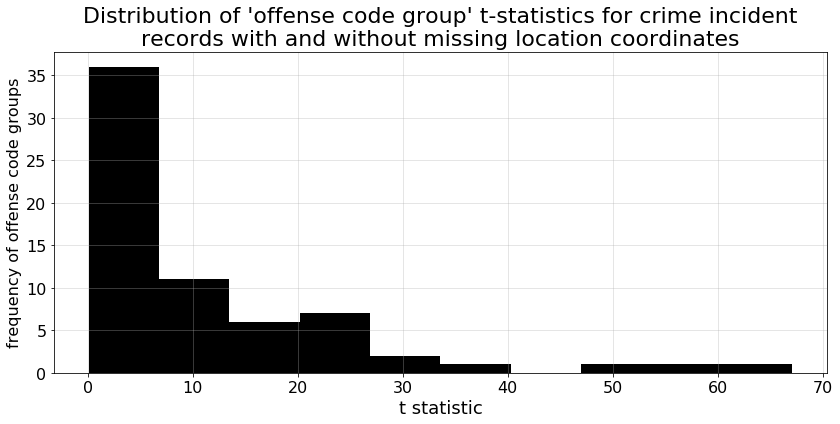

In [35]:
# print summary of years for all data records to identify partial years

savefig = True

fig, ax = plt.subplots(figsize=(12, 6))

plt.title(
    "Distribution of 'offense code group' t-statistics for crime incident\n"\
    "records with and without missing location coordinates",
    fontsize=22,
)

plt.hist(offense_group_tstats, color='k')

ax.tick_params(labelsize=16)
ax.set_ylabel("frequency of offense code groups", fontsize=16)
ax.set_xlabel("t statistic", fontsize=18)
ax.grid(':', alpha=0.4)    
plt.tight_layout()
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'crime-missing-coords-offense-tstat-hist.png'))
plt.show();

In [36]:
tstat_thresh = 10

print(
    'For the {0:,} types of "OFFENSE_CODE_GROUPS", these following groups have t-statistics '\
    'greater than {1}:\n\n{2}'.format(
        len(offense_group_tstats),
        tstat_thresh,
        offense_group_tstats.loc[offense_group_tstats > tstat_thresh]
    )
)


For the 66 types of "OFFENSE_CODE_GROUPS", these following groups have t-statistics greater than 10:

motor vehicle accident response    67.075538
verbal disputes                    59.688553
residential burglary               48.932536
larceny                            34.904300
harassment                         28.419283
missing person located             28.370429
missing person reported            24.328545
violations                         23.827485
drug violation                     23.484410
fraud                              22.696776
landlord/tenant disputes           22.479405
vandalism                          21.083502
investigate person                 20.469365
restraining order violations       17.545138
medical assistance                 17.534623
confidence games                   16.777485
commercial burglary                16.776889
counterfeiting                     14.644924
license violation                  13.571322
property lost                      12.51030

## Consolidate "OFFENSE_CODE_GROUP" values into fewer categories and inspect missing vs. non-missing coordinate records

In [37]:
# create summary table of offense groups by description
df_offense_groups_descr = df_crime.groupby(
    ['OFFENSE_CODE_GROUP', 'OFFENSE_CODE', 'OFFENSE_DESCRIPTION']
).agg({
    'INCIDENT_NUMBER': 'count',
    'is_coord': sum
})
df_offense_groups_descr = df_offense_groups_descr.rename(columns={
    'INCIDENT_NUMBER': 'INCIDENT_RECORDS',
    'is_coord': 'RECORDS_WITH_COORDS',
})
df_offense_groups_descr['PROPORTION_COORDS'] = df_offense_groups_descr['RECORDS_WITH_COORDS'] / \
                                               df_offense_groups_descr['INCIDENT_RECORDS']

# create summary table of offense groups by group
df_offense_groups = df_crime.groupby(
    'OFFENSE_CODE_GROUP'
).agg({
    'INCIDENT_NUMBER': 'count',
    'is_coord': sum
})
df_offense_groups = df_offense_groups.rename(columns={
    'INCIDENT_NUMBER': 'INCIDENT_RECORDS',
    'is_coord': 'RECORDS_WITH_COORDS',
})
df_offense_groups['PROPORTION_COORDS'] = df_offense_groups['RECORDS_WITH_COORDS'] / \
                                         df_offense_groups['INCIDENT_RECORDS']


# save resulting summary tables for further inspection for developing match categories
savetables = True

if savetables:
    df_offense_groups.to_csv(os.path.join(WRITEDIR_ROOT, 'crime-offense-group-summary.csv'))
    df_offense_groups_descr.to_csv(os.path.join(WRITEDIR_ROOT, 'crime-offense-group-description-summary.csv'))

In [44]:
# show summary of mapkey dataframe
print(df_offense_mapkey.info())
print('\n\nOffense Code Group mapping categories summary:\n')
print(
    df_offense_mapkey.groupby(['CATEGORY', 'SUB-CATEGORY']).agg({'RECORDS_WITH_COORDS': sum})
)

sample_len = 50

print(
    '\n\nOffense Code Group mapping categories with sample code group drilldown (first {0} groups):\n'\
    ''.format(sample_len)
)
print(
    df_offense_mapkey.groupby(
        ['CATEGORY', 'SUB-CATEGORY', 'OFFENSE_CODE_GROUP']
    ).agg({'RECORDS_WITH_COORDS': sum})[:sample_len]
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 6 columns):
OFFENSE_CODE_GROUP     66 non-null object
INCIDENT_RECORDS       66 non-null int64
RECORDS_WITH_COORDS    66 non-null int64
PROPORTION_COORDS      66 non-null float64
SUB-CATEGORY           66 non-null object
CATEGORY               66 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 3.2+ KB
None


Offense Code Group mapping categories summary:

                                            RECORDS_WITH_COORDS
CATEGORY               SUB-CATEGORY                            
disturbance-harassment disturbance                        15807
                       harassment                           136
drugs                  drugs                              12939
emergency              emergency-fire                      1717
                       emergency-medical                  21922
                       emergency-threat                      80
investigation     

In [45]:
################################################################
# CONSOLIDATE CRIME INCIDENT OFFENSE_CODE_GROUPS INTO CATEGORIES 
################################################################

# create mapkey dictionaries
map_subcat_dict = dict(
    zip(
        df_offense_mapkey['OFFENSE_CODE_GROUP'].values,
        df_offense_mapkey['SUB-CATEGORY'].values
    )
)

map_cat_dict = dict(
    zip(
        df_offense_mapkey['OFFENSE_CODE_GROUP'].values,
        df_offense_mapkey['CATEGORY'].values
    )
)

# map values for categories and sub-categories
df_crime['offense-category'] = df_crime['OFFENSE_CODE_GROUP'].map(map_cat_dict)
df_crime['offense-subcategory'] = df_crime['OFFENSE_CODE_GROUP'].map(map_subcat_dict)

In [46]:
# review mapping results
print(df_crime['offense-category'].value_counts(dropna=False))
print()
print(df_crime['offense-subcategory'].value_counts(dropna=False))

larceny                   72932
motor-vehicle             57118
other                     50329
investigation             35333
property-vandalism        34263
violence-aggression       32751
emergency                 31104
disturbance-harassment    19962
drugs                     18340
violations                13056
Name: offense-category, dtype: int64

motor-vehicle          57118
theft                  48541
investigation          35333
emergency-medical      28881
assault                27335
other                  20873
disturbance            19809
drugs                  18340
property               17212
vandalism              17051
violations             13056
fraud                  12423
missing-person         10393
warrant-arrest          9604
burglary                7216
harassment              5236
robbery                 4752
weapons                 3905
police-service          3246
emergency-fire          2129
warrant-search          1131
nonviolent-domestic      550
pris

In [47]:
# Review t-statistics for coord vs. non-coord offense categories

# create a one-hot encoded subset dataframe containing only categories
# for 'offense-category' and 'offense-subcategory' 
df_offense_cats = pd.get_dummies(df_crime['offense-category'])
df_offense_subcats = pd.get_dummies(df_crime['offense-subcategory'])

# calculate t-stats for offense group records with and without coordinates
offense_cat_tstats = calc_t_stats(df_offense_cats, df_crime['is_coord'], sort=True)
offense_subcat_tstats = calc_t_stats(df_offense_subcats, df_crime['is_coord'], sort=True)

In [48]:
print(
    'Calculated t-statistics for each offense CATEGORY for missing vs. '\
    'non-missing coordinate records are:\n\n{0}\n\n'\
    'And, for each offense SUB-CATEGORY are:\n\n{1}\n'.format(
        offense_cat_tstats,
        offense_subcat_tstats
    )
)

Calculated t-statistics for each offense CATEGORY for missing vs. non-missing coordinate records are:

motor-vehicle             62.600727
larceny                   41.792724
disturbance-harassment    41.553281
investigation             23.676296
drugs                     23.484410
property-vandalism        21.120297
emergency                 19.381587
violations                16.447216
violence-aggression        9.778135
other                      4.849584
dtype: float64

And, for each offense SUB-CATEGORY are:

motor-vehicle          62.600727
burglary               48.125374
disturbance            41.099197
missing-person         37.446665
fraud                  32.629708
harassment             29.410827
theft                  27.257794
investigation          23.676296
drugs                  23.484410
vandalism              21.083502
emergency-medical      17.534623
violations             16.447216
emergency-fire          9.870011
home invasion           9.592948
property          

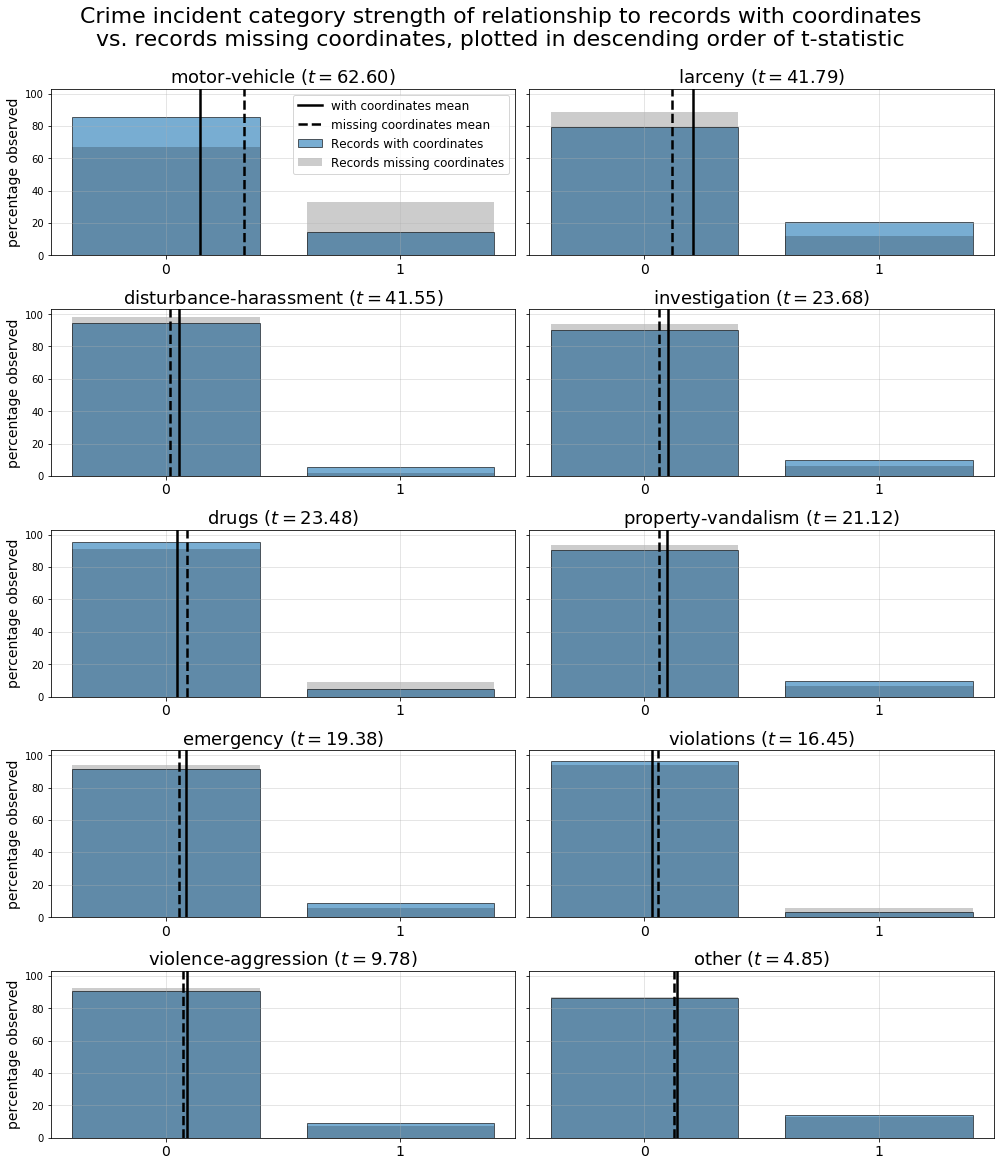

In [49]:
# print barplots for each offense category in descending order of t-stat
# illustrating missing vs. non-missing coordinate records

savefig = True

# identify which rows belong to each coord class
bool_1 = (df_crime['is_coord'].loc[:] == 1).values
bool_0 = (df_crime['is_coord'].loc[:] == 0).values

# subset top 6 predictors by t-stat for plotting
# t_stats_top_6 = t_stats_best_10[:6].index

# subset data by coord class for easier plotting
coord_df = df_offense_cats.loc[bool_1]
nocoord_df = df_offense_cats.loc[bool_0]
coord_len = len(coord_df)
nocoord_len = len(nocoord_df)

# plot histograms of the top 4 predictors from the training data
fig, axes = plt.subplots(5,2, sharex=False, sharey=True, figsize=(14,17))

plt.suptitle(
    "Crime incident category strength of relationship to records with coordinates\n"\
    "vs. records missing coordinates, plotted in descending order of t-statistic",
    fontsize=22
)

for (i, ax), var in zip(enumerate(axes.flatten()), offense_cat_tstats.index):
    ax.bar(
        coord_df[var].value_counts().index,
        coord_df[var].value_counts().values / coord_len * 100,
        color='tab:blue', edgecolor='k', alpha=0.6, label='Records with coordinates'
    )
    ax.axvline(
        coord_df[var].mean(),
        linestyle='-', color='k', linewidth=2.5, label='with coordinates mean'
    )
    ax.bar(
        nocoord_df[var].value_counts().index,
        nocoord_df[var].value_counts().values / nocoord_len * 100,
        color='k', alpha=0.2, label='Records missing coordinates'
    )

    ax.axvline(
        nocoord_df[var].mean(),
        color='k', linestyle='--', linewidth=2.5, label='missing coordinates mean'
    )
    ax.set_xticks([0,1])
    ax.set_xticklabels([0,1], fontsize=14)
    ax.grid(":", alpha=0.4)
    ax.set_title(
        '{0} ($t={1:.2f}$)'.format(var, offense_cat_tstats.loc[var]),
        fontsize=18
    )
    if i % 2 == 0:
        ax.set_ylabel('percentage observed', fontsize=14)
    
axes[0,0].legend(fontsize=12, markerscale=1.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.94])
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'crime-offense-cats-missing-coords-tstat-barplots.png'))
plt.show();

## INVESTIGATE CATEGORY MAP KEY VERSION 2

In [56]:
df_offense_mapkey_2 = pd.read_csv(readfile_crime_match_key_2)

In [57]:
# show summary of mapkey dataframe
print(df_offense_mapkey_2.info())
print('\n\nOffense Code Group mapping categories summary:\n')
print(
    df_offense_mapkey_2.groupby('CATEGORY').agg({'RECORDS_WITH_COORDS': sum})
)

sample_len = 50

print(
    '\n\nOffense Code Group mapping categories with sample code group drilldown (first {0} groups):\n'\
    ''.format(sample_len)
)
print(
    df_offense_mapkey_2.groupby(
        ['CATEGORY', 'OFFENSE_CODE_GROUP']
    ).agg({'RECORDS_WITH_COORDS': sum})
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 5 columns):
OFFENSE_CODE_GROUP     66 non-null object
INCIDENT_RECORDS       66 non-null int64
RECORDS_WITH_COORDS    66 non-null int64
PROPORTION_COORDS      66 non-null float64
CATEGORY               45 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 2.7+ KB
None


Offense Code Group mapping categories summary:

                        RECORDS_WITH_COORDS
CATEGORY                                   
burglary                               7157
drugs-substances                      16528
fraud                                 12130
harassment-disturbance                26279
other                                  8084
robbery                                4317
theft                                 43770
vandalism-property                    17360
violence-aggression                   26945


Offense Code Group mapping categories with sample code group drilldown (first 50 group

In [58]:
################################################################
# CONSOLIDATE CRIME INCIDENT OFFENSE_CODE_GROUPS INTO CATEGORIES 
################################################################

# create mapkey dictionaries
map_cat_dict_2 = dict(
    zip(
        df_offense_mapkey_2['OFFENSE_CODE_GROUP'].values,
        df_offense_mapkey_2['CATEGORY'].values
    )
)

# map values for categories and sub-categories
df_crime['crime-type'] = df_crime['OFFENSE_CODE_GROUP'].map(map_cat_dict_2)

In [59]:
# review mapping results
print(df_crime['crime-type'].value_counts(dropna=False))

NaN                       193599
theft                      45708
violence-aggression        28801
harassment-disturbance     26857
drugs-substances           18946
vandalism-property         18074
fraud                      12423
other                       8812
burglary                    7216
robbery                     4752
Name: crime-type, dtype: int64


In [63]:
# Review t-statistics for coord vs. non-coord offense categories

# create a one-hot encoded subset dataframe containing only categories
# for 'offense-category' and 'offense-subcategory' 
df_offense_cats_2 = pd.get_dummies(df_crime['crime-type'])

# calculate t-stats for offense group records with and without coordinates
offense_cat_tstats_2 = calc_t_stats(df_offense_cats_2, df_crime['is_coord'], sort=True)

In [65]:
print(
    'Calculated t-statistics for each offense CATEGORY for missing vs. '\
    'non-missing coordinate records are:\n\n{0}\n'.format(
        offense_cat_tstats_2
    )
)

Calculated t-statistics for each offense CATEGORY for missing vs. non-missing coordinate records are:

harassment-disturbance    52.471871
burglary                  48.125374
fraud                     32.629708
theft                     29.893248
drugs-substances          24.750822
vandalism-property        20.877103
robbery                    5.265103
other                      4.483782
violence-aggression        3.729976
dtype: float64



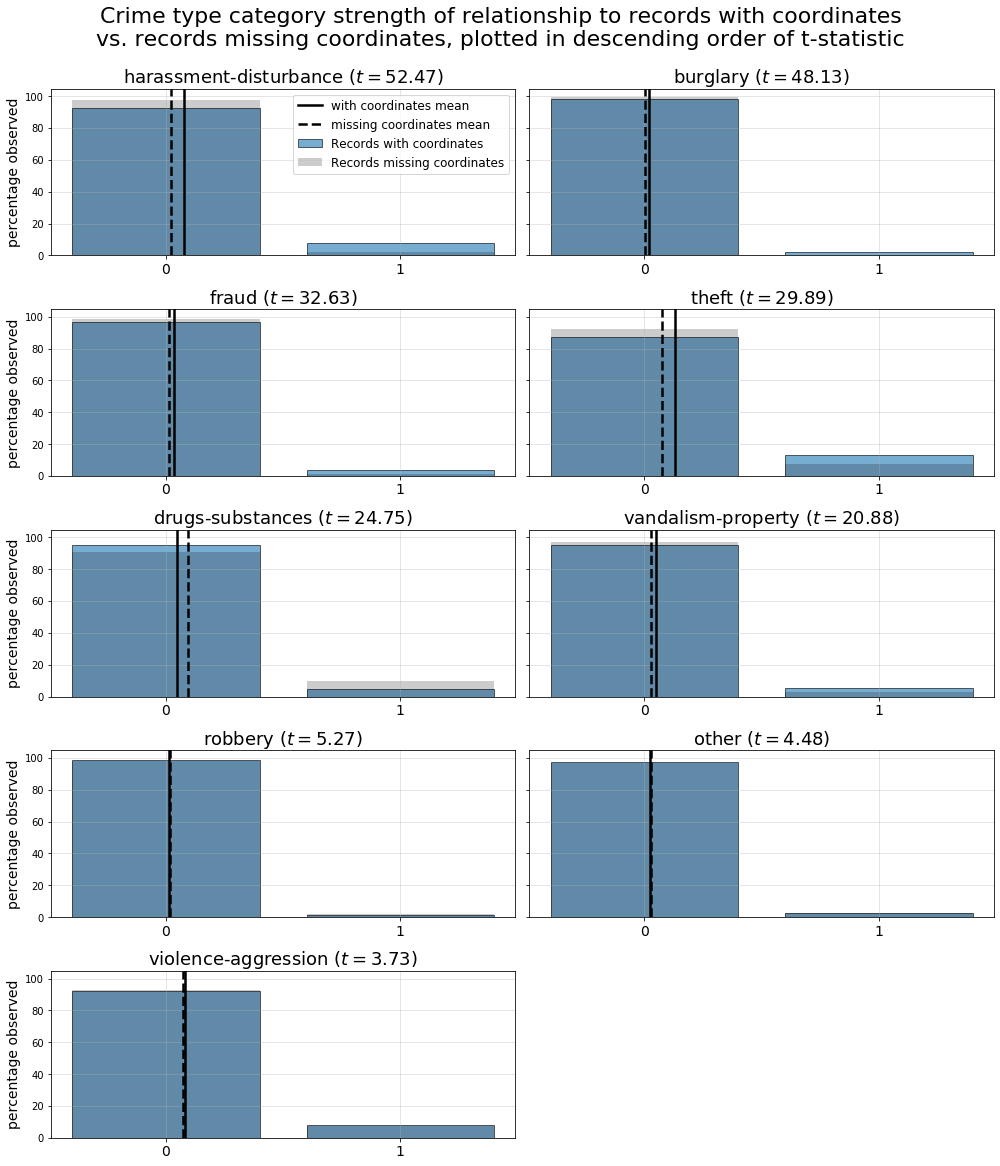

In [68]:
# print barplots for each offense category in descending order of t-stat
# illustrating missing vs. non-missing coordinate records

savefig = True

# identify which rows belong to each coord class
bool_1 = (df_crime['is_coord'].loc[:] == 1).values
bool_0 = (df_crime['is_coord'].loc[:] == 0).values

# subset top 6 predictors by t-stat for plotting
# t_stats_top_6 = t_stats_best_10[:6].index

# subset data by coord class for easier plotting
coord_df = df_offense_cats_2.loc[bool_1]
nocoord_df = df_offense_cats_2.loc[bool_0]
coord_len = len(coord_df)
nocoord_len = len(nocoord_df)

# plot histograms of the top 4 predictors from the training data
fig, axes = plt.subplots(5,2, sharex=False, sharey=True, figsize=(14,17))

plt.suptitle(
    "Crime type category strength of relationship to records with coordinates\n"\
    "vs. records missing coordinates, plotted in descending order of t-statistic",
    fontsize=22
)

for (i, ax), var in zip(enumerate(axes.flatten()), offense_cat_tstats_2.index):
    ax.bar(
        coord_df[var].value_counts().index,
        coord_df[var].value_counts().values / coord_len * 100,
        color='tab:blue', edgecolor='k', alpha=0.6, label='Records with coordinates'
    )
    ax.axvline(
        coord_df[var].mean(),
        linestyle='-', color='k', linewidth=2.5, label='with coordinates mean'
    )
    ax.bar(
        nocoord_df[var].value_counts().index,
        nocoord_df[var].value_counts().values / nocoord_len * 100,
        color='k', alpha=0.2, label='Records missing coordinates'
    )

    ax.axvline(
        nocoord_df[var].mean(),
        color='k', linestyle='--', linewidth=2.5, label='missing coordinates mean'
    )
    ax.set_xticks([0,1])
    ax.set_xticklabels([0,1], fontsize=14)
    ax.grid(":", alpha=0.4)
    ax.set_title(
        '{0} ($t={1:.2f}$)'.format(var, offense_cat_tstats_2.loc[var]),
        fontsize=18
    )
    if i % 2 == 0:
        ax.set_ylabel('percentage observed', fontsize=14)
    
# hide all markings for final 10th axis    
for pos in ['right','top','bottom','left']:
    axes[4,1].spines[pos].set_visible(False)
axes[4,1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axes[4,1].tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

axes[0,0].legend(fontsize=12, markerscale=1.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.94])
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'crime-types-missing-coords-tstat-barplots.png'))
plt.show();

## Subset crime incident data to include only records with coordinates and begin adding features

In [76]:
#################################################################################
## SUBSET DATAFRAME AND KEEP ONLY RECORDS WITH COORDINATES AND CRIME TYPE CLASSES
#################################################################################

print(
    'The full crime incident dataset has the following shape:\n\n{}\n'\
    ''.format(df_crime.shape)
)

df_crime = df_crime.loc[(df_crime['is_coord']==1) & ~(df_crime['crime-type'].isnull())]

print(
    'The new crime incident dataset subsetted to include only records with '\
    'coordinates and "crime-type" classes assigned to them has the following shape:\n\n{}\n'\
    ''.format(df_crime.shape)
)

The full crime incident dataset has the following shape:

(162570, 53)

The new crime incident dataset subsetted to include only records with coordinates and "crime-type" classes assigned to them has the following shape:

(162570, 53)



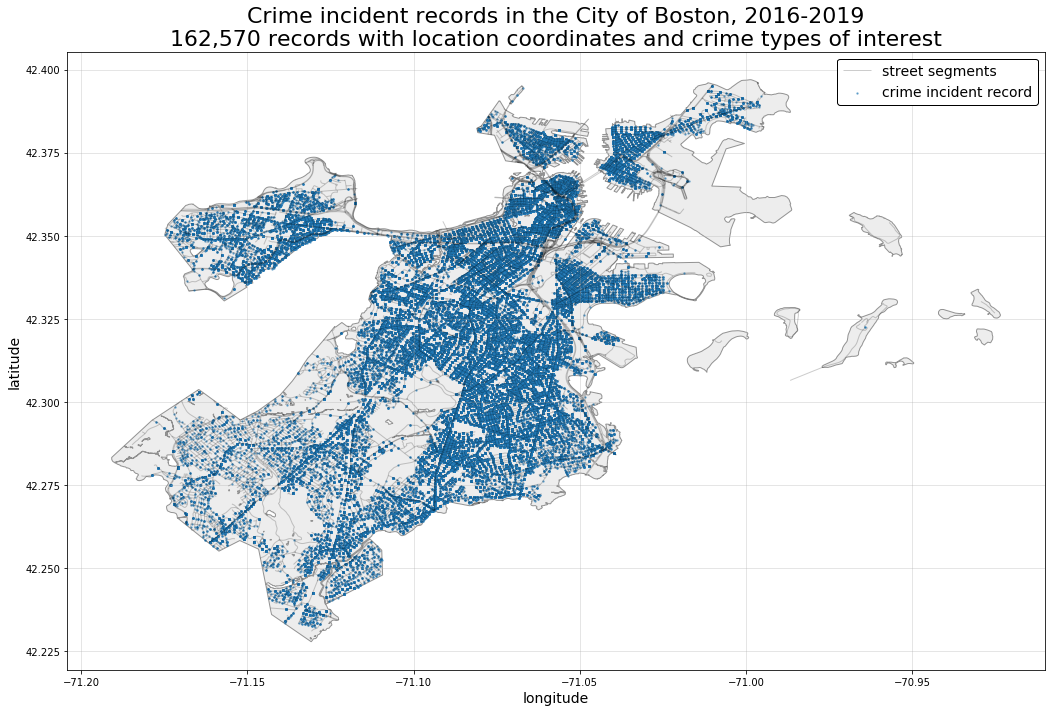

CPU times: user 3.11 s, sys: 3.9 ms, total: 3.11 s
Wall time: 3.11 s


In [77]:
%%time
savefig=True

# plot unique SAM records with city boundary and street segments overlays 
fig, ax = plt.subplots(figsize=(16,10))
gdf_boston.plot(ax=ax, color='lightgray', edgecolor='k', alpha=0.4)
gdf_streets.plot(ax=ax, color='k', linewidth=1, alpha=0.2, label='street segments')
plt.title(
    'Crime incident records in the City of Boston, {0}-{1}\n'\
    '{2:,} records with location coordinates and crime types of interest'.format(
        min(subset_years),
        max(subset_years),
        df_crime['is_coord'].sum(),
    ),
    fontsize=22
)
plt.scatter(
    df_crime['Long'], df_crime['Lat'],
    color='tab:blue', alpha=0.5, s=2,
    label='crime incident record'
)
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
plt.grid(":", alpha=0.4)
plt.legend(edgecolor='k', framealpha=1, fontsize=14)
plt.tight_layout()
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'crime-incidents-with-coords-of-interest.png'))
plt.show();

In [78]:
# Prepare data for plotting crime incident choropleths

# set a few parameters for preparing data
shapedim_list = ['ZIP5_zipcode', 'Name_neighborhood', 'TRACTCE10_censustract']
joincol_list = ['ZIP5', 'Name', 'TRACTCE10']
shapetype_list = ['zipcode', 'neighborhood', 'census tract']

# create groupby counts for each shape of interest
crime_by_shape_list = [
    df_crime.groupby(shapedim).agg({
        'INCIDENT_NUMBER': 'count'
    }).rename({'INCIDENT_NUMBER': 'incidents'}, axis=1)
    for shapedim in shapedim_list
]

# label each shape in shapefile with shapename at representative coordinate
for gdf in [gdf_zips, gdf_hoods, gdf_tracts]:
    gdf['coords'] = gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
    gdf['coords'] = [coords[0] for coords in gdf['coords']]

# create joins with shapefiles to append with groupy counts for plotting
gdf_by_shape_dict = {
    shapetype: gdf.join(crime_by_shape, on=joincol)
    for shapetype, gdf, crime_by_shape, joincol in zip(
        shapetype_list,
        [gdf_zips, gdf_hoods, gdf_tracts],
        crime_by_shape_list,
        joincol_list
    )
}


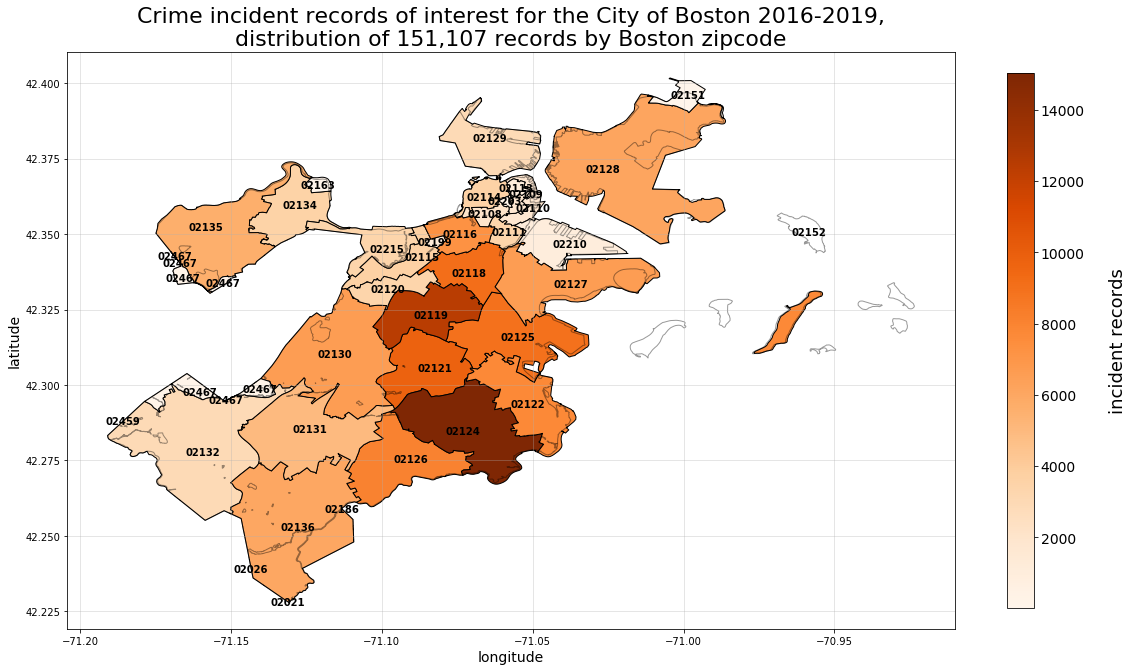

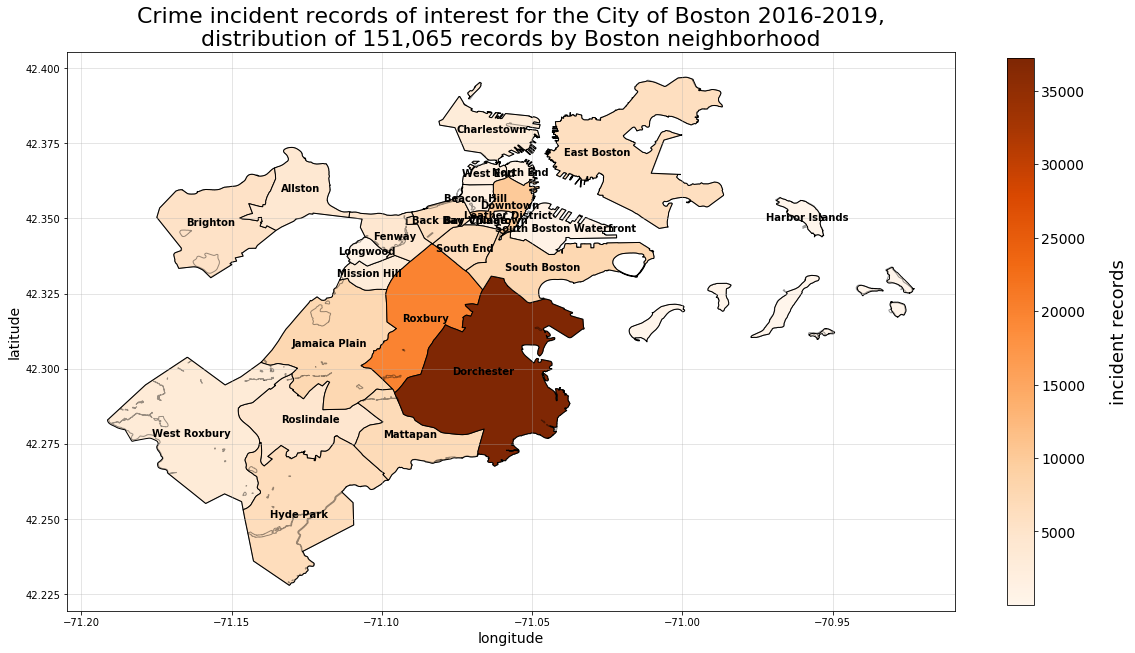

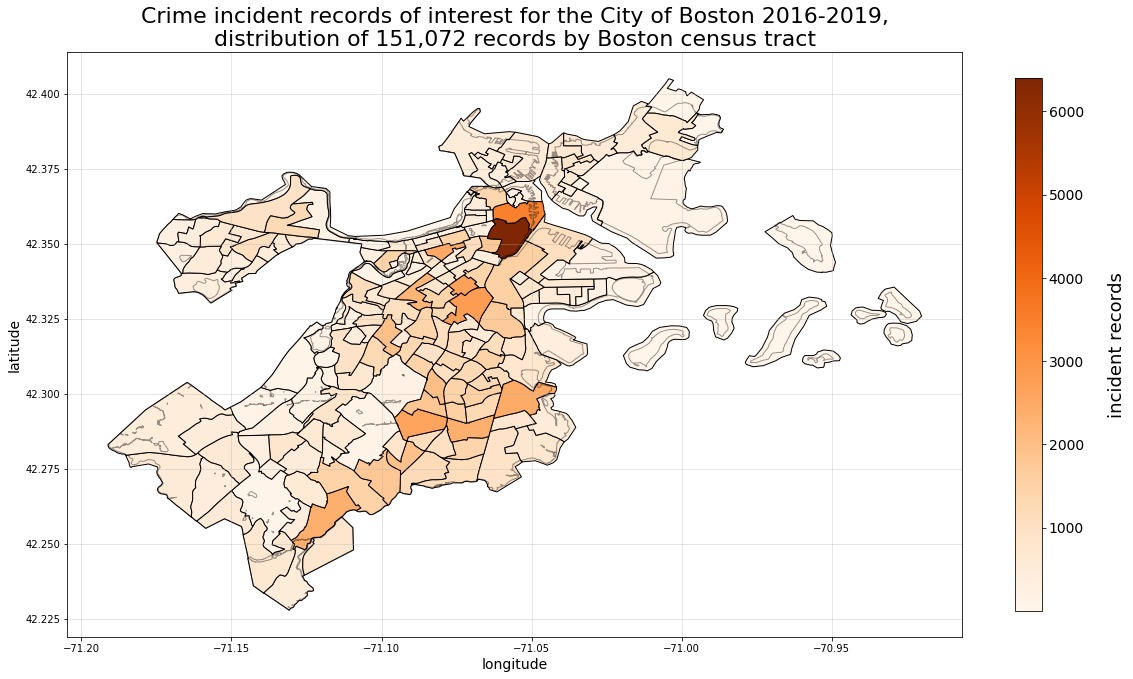

In [79]:
# Plot and save choropleths

# only label zipcodes and neighborhood, but not census tracts beacuse too small
labels_list = [joincol_list[0], joincol_list[1], None]

# set chart titles
titles_list = [
    'Crime incident records of interest for the City of Boston {0}-{1},\n'\
    'distribution of {2:,} records by Boston {3}'.format(
        min(subset_years),
        max(subset_years),
        crime_by_shape.sum()[0],
        shapetype
    ) for shapetype, crime_by_shape in zip(
        shapetype_list, crime_by_shape_list
    )
]

# set savepaths
savepaths_list = [
    os.path.join(FIGURES_ROOT, 'crime-reports-FINAL-by-{}.png'.format(shapetype))
    for shapetype in shapetype_list
]

for gdf, labels, title, savepath in zip(
    gdf_by_shape_dict.values(), labels_list, titles_list, savepaths_list
):
    make_choropleth(
        gdf, variable='incidents', title=title, cb_label='incident records',
        cmap='Oranges', labels=labels, savepath=savepath, citybounds=True
    )

## Drop unnecessary columns from dataset

In [82]:
#####################################################
## FIRST SAVE A COPY OF THE CURRENT SUBSETTED DATASET
#####################################################

df_crime.to_csv(os.path.join(WRITEDIR_ROOT, 'crime_records_subset_by_type.csv'), index=False)

In [81]:
print(df_crime.info())
df_crime.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162570 entries, 403 to 427170
Data columns (total 53 columns):
INCIDENT_NUMBER             162570 non-null object
OFFENSE_CODE                162570 non-null object
OFFENSE_CODE_GROUP          162570 non-null object
OFFENSE_DESCRIPTION         162570 non-null object
DISTRICT                    162260 non-null object
REPORTING_AREA              162570 non-null object
SHOOTING                    1151 non-null object
OCCURRED_ON_DATE            162570 non-null object
YEAR                        162570 non-null object
MONTH                       162570 non-null int64
DAY_OF_WEEK                 162570 non-null object
HOUR                        162570 non-null int64
UCR_PART                    162468 non-null object
STREET                      161784 non-null object
Lat                         162570 non-null float64
Long                        162570 non-null float64
Location                    162570 non-null object
is_coord              

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,...,AWATER10_censustract,INTPTLAT10_censustract,INTPTLON10_censustract,Shape_STAr_censustract,Shape_STLe_censustract,Shape__Are_censustract,Shape__Len_censustract,offense-category,offense-subcategory,crime-type
403,I192078177,01001,counterfeiting,forgery / counterfeiting,E13,570,NaN,2019-08-01 17:46:00,2019,8,...,27540.0,+42.3006134,-071.0946130,2.264058e+07,21193.489288,3.847996e+06,8740.783639,larceny,fraud,fraud
504,I192078061,02629,harassment,harassment,D14,939,NaN,2019-06-12 21:00:00,2019,6,...,0.0,+42.3526051,-071.1543443,6.475527e+06,12739.927991,1.102313e+06,5255.263484,violence-aggression,harassment,harassment-disturbance
526,I192078038,00615,larceny from motor vehicle,larceny theft of mv parts & accessories,C6,210,NaN,2019-03-10 08:00:00,2019,3,...,632511.0,+42.3495755,-071.0422812,2.037980e+07,29807.691008,3.468814e+06,12298.240056,larceny,theft,theft
547,I192078015,00619,larceny,larceny all others,C6,201,NaN,2019-07-08 10:29:00,2019,7,...,0.0,+42.3385217,-071.0539041,1.380120e+06,4777.787105,2.348302e+05,1970.767246,larceny,theft,theft
561,I192077997,00727,auto theft,auto theft - leased/rented vehicle,C6,178,NaN,2019-04-13 08:00:00,2019,4,...,0.0,+42.3293317,-071.0705291,1.104717e+07,18648.501823,1.879155e+06,7693.603281,larceny,theft,theft


In [96]:
df_crime['SqMiles_neighborhood'].iloc[0] / df_crime['ShapeSTAre_neighborhood'].iloc[0]

3.582139761355166e-08

In [90]:
df_crime.iloc[0,-5] / df_crime.iloc[0,-7]

0.16996015083951224

In [84]:
df_crime.iloc[:6,-8:]

,INTPTLON10_censustract,Shape_STAr_censustract,Shape_STLe_censustract,Shape__Are_censustract,Shape__Len_censustract,offense-category,offense-subcategory,crime-type
403,-071.0946130,2.264058e+07,21193.489288,3.847996e+06,8740.783639,larceny,fraud,fraud
504,-071.1543443,6.475527e+06,12739.927991,1.102313e+06,5255.263484,violence-aggression,harassment,harassment-disturbance
526,-071.0422812,2.037980e+07,29807.691008,3.468814e+06,12298.240056,larceny,theft,theft
547,-071.0539041,1.380120e+06,4777.787105,2.348302e+05,1970.767246,larceny,theft,theft
561,-071.0705291,1.104717e+07,18648.501823,1.879155e+06,7693.603281,larceny,theft,theft
567,-071.0705291,1.104717e+07,18648.501823,1.879155e+06,7693.603281,larceny,theft,theft


In [102]:
keep_cols_dict = {
    'crime-type': 'crime-type',
    'INCIDENT_NUMBER': 'INCIDENT_NUMBER',
    'OFFENSE_DESCRIPTION': 'OFFENSE_DESCRIPTION',
    'OCCURRED_ON_DATE': 'timestamp',
    'Lat': 'lat',
    'Long': 'lon',
    'YEAR': 'year',
    'MONTH': 'month',
    'DAY_OF_WEEK': 'day-of-week',
    'HOUR': 'hour',
    'ZIP5_zipcode': 'ZIP5', # shape names are reverted to original for matching ease
    'ShapeSTAre_zipcode': 'ZIP5_area',
    'Name_neighborhood': 'Name',
    'ShapeSTAre_neighborhood': 'Neighborhood_area',
    'SqMiles_neighborhood': 'Neighborhood_area_2',
    'TRACTCE10_censustract': 'TRACTCE10',
    'Shape_STAr_censustract': 'TRACTCE10_area',
    'Shape__Are_censustract': 'TRACTCE10_area_2',
}

In [108]:
crime_df = df_crime[keep_cols_dict.keys()].rename(columns=keep_cols_dict)
crime_df['year'] = crime_df['year'].astype(int)

In [128]:
# drop observations with no census tract associated
crime_df = crime_df.loc[~crime_df['TRACTCE10'].isnull()]

In [129]:
print(crime_df.info())
crime_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151072 entries, 403 to 373578
Data columns (total 18 columns):
crime-type             151072 non-null object
INCIDENT_NUMBER        151072 non-null object
OFFENSE_DESCRIPTION    151072 non-null object
timestamp              151072 non-null object
lat                    151072 non-null float64
lon                    151072 non-null float64
year                   151072 non-null int64
month                  151072 non-null int64
day-of-week            151072 non-null object
hour                   151072 non-null int64
ZIP5                   151044 non-null object
ZIP5_area              151044 non-null float64
Name                   151002 non-null object
Neighborhood_area      151002 non-null float64
Neighborhood_area_2    151002 non-null float64
TRACTCE10              151072 non-null object
TRACTCE10_area         151072 non-null float64
TRACTCE10_area_2       151072 non-null float64
dtypes: float64(7), int64(3), object(8)
memory usage: 2

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,ZIP5,ZIP5_area,Name,Neighborhood_area,Neighborhood_area_2,TRACTCE10,TRACTCE10_area,TRACTCE10_area_2
403,fraud,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,02130,1.052212e+08,Roxbury,9.184455e+07,3.29,980300,2.264058e+07,3.847996e+06
504,harassment-disturbance,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,02135,7.862083e+07,Brighton,8.016788e+07,2.88,000202,6.475527e+06,1.102313e+06
526,theft,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,02210,3.237321e+07,South Boston Waterfront,2.708740e+07,0.97,060600,2.037980e+07,3.468814e+06
547,theft,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,02127,6.753614e+07,South Boston,6.272131e+07,2.25,060700,1.380120e+06,2.348302e+05
561,theft,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,02119,4.451150e+07,Roxbury,9.184455e+07,3.29,080100,1.104717e+07,1.879155e+06


## Add property-related engineered features

In [106]:
df_feat_prop = pd.read_csv(readfile_feat_property, dtype={'shape-id': str, 'fiscal-year': int})

In [110]:
print(df_feat_prop.info())
df_feat_prop.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13002 entries, 0 to 13001
Data columns (total 5 columns):
shape-id       13002 non-null object
fiscal-year    13002 non-null int64
value          12927 non-null float64
shape-type     13002 non-null object
metric         13002 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 508.0+ KB
None


,shape-id,fiscal-year,value,shape-type,metric
0,00000,2013,37000.0,zipcode,residential-median-value
1,02026,2013,NaN,zipcode,residential-median-value
2,02108,2013,691300.0,zipcode,residential-median-value
3,02109,2013,456950.0,zipcode,residential-median-value
4,02110,2013,566512.5,zipcode,residential-median-value


In [112]:
# keep only census tract level metrics
df_feat_prop = df_feat_prop.loc[df_feat_prop['shape-type']=='census tract']
df_feat_prop.shape

(9570, 5)

In [115]:
# make list of metrics for matching
print(df_feat_prop['metric'].value_counts())

prop_metrics_list = list(df_feat_prop['metric'].value_counts().index)

print()
print(prop_metrics_list)

commercial-mix-ratio                 1267
industrial-mix-ratio                 1267
owner-occupied-ratio                 1190
residential-median-value             1183
residential-gini-coef                1183
industrial-mix-ratio-3yr-cagr         724
commercial-mix-ratio-3yr-cagr         724
owner-occupied-ratio-3yr-cagr         680
residential-median-value-3yr-cagr     676
residential-gini-coef-3yr-cagr        676
Name: metric, dtype: int64

['commercial-mix-ratio', 'industrial-mix-ratio', 'owner-occupied-ratio', 'residential-median-value', 'residential-gini-coef', 'industrial-mix-ratio-3yr-cagr', 'commercial-mix-ratio-3yr-cagr', 'owner-occupied-ratio-3yr-cagr', 'residential-median-value-3yr-cagr', 'residential-gini-coef-3yr-cagr']


In [155]:
crime_df['tract-match-key'] = (crime_df['TRACTCE10'].astype(str) + crime_df['year'].astype(str)).values

crime_df['tract-match-key'].head()

403    9803002019
504    0002022019
526    0606002019
547    0607002019
561    0801002019
Name: tract-match-key, dtype: object

In [136]:
df_feat_prop['shape_match'] = (df_feat_prop['shape-id'].astype(str) + df_feat_prop['fiscal-year'].astype(str)).values
df_feat_prop.head()

,shape-id,fiscal-year,value,shape-type,metric,shape_match
420,000100,2013,402150.0,census tract,residential-median-value,0001002013
421,000201,2013,444900.0,census tract,residential-median-value,0002012013
422,000202,2013,447581.0,census tract,residential-median-value,0002022013
423,000301,2013,412700.0,census tract,residential-median-value,0003012013
424,000302,2013,326650.0,census tract,residential-median-value,0003022013


In [142]:
df_feat_prop.loc[
            (df_feat_prop['metric']==prop_metrics_list[0]) &
            (df_feat_prop['shape_match']==shape_match_array[20])
        ]['value'].iloc[0]

0.05364285006226532

In [158]:
for metric in prop_metrics_list:
    temp_match_dict = dict(
        zip(
            df_feat_prop.loc[df_feat_prop['metric']==metric][['value', 'shape_match']].values[:,1],
            df_feat_prop.loc[df_feat_prop['metric']==metric][['value', 'shape_match']].values[:,0]
        )
    )
    crime_df[metric] = crime_df['tract-match-key'].copy().map(temp_match_dict)

In [159]:
print(crime_df.info())
crime_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151072 entries, 403 to 373578
Data columns (total 29 columns):
crime-type                           151072 non-null object
INCIDENT_NUMBER                      151072 non-null object
OFFENSE_DESCRIPTION                  151072 non-null object
timestamp                            151072 non-null object
lat                                  151072 non-null float64
lon                                  151072 non-null float64
year                                 151072 non-null int64
month                                151072 non-null int64
day-of-week                          151072 non-null object
hour                                 151072 non-null int64
ZIP5                                 151044 non-null object
ZIP5_area                            151044 non-null float64
Name                                 151002 non-null object
Neighborhood_area                    151002 non-null float64
Neighborhood_area_2                  151002 no

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,...,commercial-mix-ratio,industrial-mix-ratio,owner-occupied-ratio,residential-median-value,residential-gini-coef,industrial-mix-ratio-3yr-cagr,commercial-mix-ratio-3yr-cagr,owner-occupied-ratio-3yr-cagr,residential-median-value-3yr-cagr,residential-gini-coef-3yr-cagr
403,fraud,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,...,0.000000,0.000294,0.000000,756500.0,0.000000,-0.034814,0.000000,0.000000,0.024264,0.000000
504,harassment-disturbance,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,...,0.069416,0.000000,0.550355,745950.0,0.199606,0.000000,-0.010424,-0.028224,0.068142,0.011166
526,theft,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,...,0.478130,0.000938,0.456287,538500.0,0.228793,-0.084828,0.010549,-0.014131,0.060340,0.018436
547,theft,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,...,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
561,theft,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,...,0.375058,0.076862,0.460751,355500.0,0.172898,0.060168,-0.007779,-0.023444,0.082123,0.025972


In [160]:
print(df_crime['crime-type'].value_counts(dropna=False).sort_index())
print()
print(list(df_crime['crime-type'].value_counts(dropna=False).sort_index().index))

burglary                   7157
drugs-substances          16528
fraud                     12130
harassment-disturbance    26279
other                      8084
robbery                    4317
theft                     43770
vandalism-property        17360
violence-aggression       26945
Name: crime-type, dtype: int64

['burglary', 'drugs-substances', 'fraud', 'harassment-disturbance', 'other', 'robbery', 'theft', 'vandalism-property', 'violence-aggression']


In [162]:
crime_df.to_csv(os.path.join(DATA_ROOT, 'processed/crime-model-data-v1.csv'), index=False)

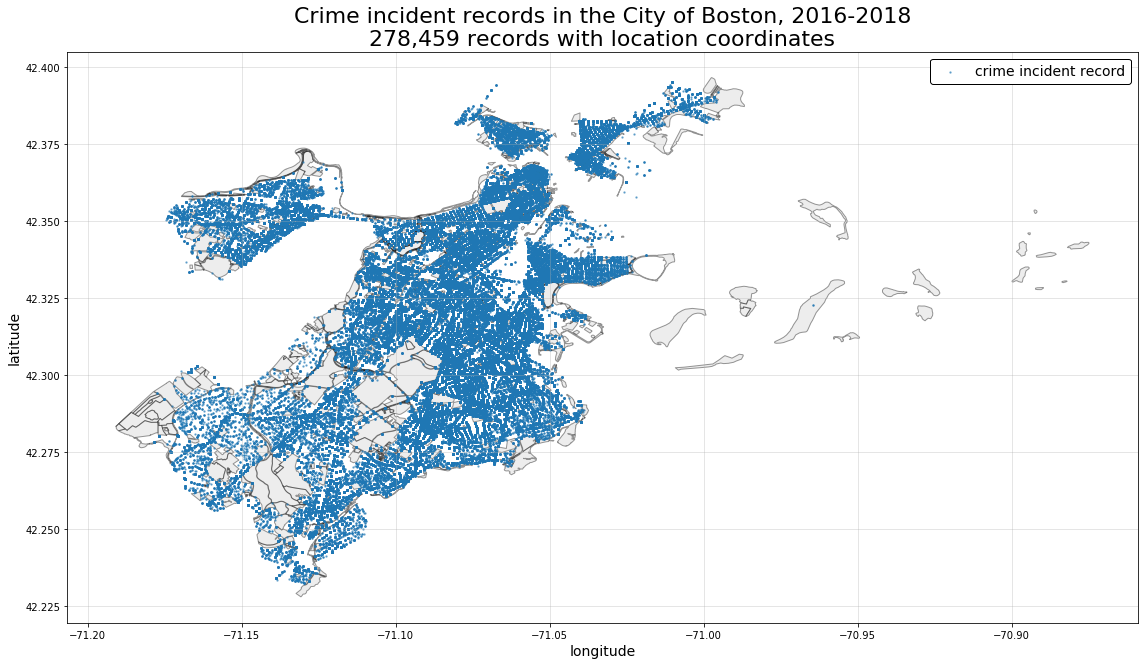

CPU times: user 3.75 s, sys: 48 ms, total: 3.8 s
Wall time: 3.2 s


In [35]:
%%time
savefig=False

# plot unique SAM records with city boundary and street segments overlays 
fig, ax = plt.subplots(figsize=(16,10))
gdf_openspace.plot(ax=ax, color='lightgray', edgecolor='k', alpha=0.4)
# gdf_streets.plot(ax=ax, color='k', linewidth=1, alpha=0.2, label='street segments')
plt.title(
    'Crime incident records in the City of Boston, {0}-{1}\n'\
    '{2:,} records with location coordinates'.format(
        min(subset_years),
        max(subset_years),
        df_crime['is_coord'].sum(),
    ),
    fontsize=22
)
plt.scatter(
    df_crime['Long'], df_crime['Lat'],
    color='tab:blue', alpha=0.5, s=2,
    label='crime incident record'
)
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
plt.grid(":", alpha=0.4)
plt.legend(edgecolor='k', framealpha=1, fontsize=14)
plt.tight_layout()
# if savefig:
#     plt.savefig(os.path.join(FIGURES_ROOT, 'crime-incidents-with-coords.png'))
plt.show();